<a href="https://colab.research.google.com/github/NatP-dev/Case_06/blob/main/Daily_Interest_Rates_Data_Analysis_27052025_1915.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Daily Interest Rates**

#### **Author**: Group X

## **<font color='#474747'>0 - Imports**</font>



In [189]:
################################ LIBRARIES ########################
# -------------------------- Core Libraries -------------------------- #
import os
import pandas as pd
import re
from IPython.display import display
import numpy as np


# -------------------------- Plotting -------------------------- #
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from scipy.stats import zscore
import plotly.graph_objects as go
from collections import Counter
from collections import defaultdict


from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, nearest_workday, Easter, GoodFriday, EasterMonday



---
---
<br><br>
# **<font color='#000058'>Chapter 1: Data</font>**



## **<font color='#474747'>1.1 - Load All Data Files**

In [190]:
# Step 1: Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [191]:
# Step 2: Set the path to your folder containing the 31 CSV files
# Replace this path with the actual folder path inside your Drive
folder_path = '/content/drive/MyDrive/EMAS 14 Case 6/Data/Interest Rates/Daily'


In [192]:
# Step 3: Load all CSV files into a list of DataFrames
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Optional: Sort filenames to maintain a consistent order
csv_files.sort()

In [193]:
# Step 4: Read all CSV files
dataframes = []
for file in csv_files:
    full_path = os.path.join(folder_path, file)
    df = pd.read_csv(full_path)
    dataframes.append(df)

# Now `dataframes` is a list of 31 DataFrames (one per CSV)
# Example: access the first DataFrame
print(dataframes[0].head())

          Unnamed: 0 BBSIS.D.I.ZST.ZI.EUR.S1311.B.A604.R005X.R.A.A._Z._Z.A  \
0                NaN  Term structure of interest rates on listed Fed...      
1            Comment  Monatsendstandsreihe: WZ9807. Bis Juli 1997 li...      
2           Decimals                                                  2      
3   Time format code                                                P1D      
4  Unit (in english)                                            percent      

  BBSIS.D.I.ZST.ZI.EUR.S1311.B.A604.R005X.R.A.A._Z._Z.A_FLAGS  
0                                                NaN           
1                                                NaN           
2                                                NaN           
3                                                NaN           
4                                                NaN           


In [194]:
# Loop for files into their own dataframes
for i in range(len(dataframes)):
    print(f"DataFrame {i}: {csv_files[i]}")

DataFrame 0: daily-term-structure-spot-interest-rate-R005X.csv
DataFrame 1: daily-term-structure-spot-interest-rate-R01XX.csv
DataFrame 2: daily-term-structure-spot-interest-rate-R02XX.csv
DataFrame 3: daily-term-structure-spot-interest-rate-R03XX.csv
DataFrame 4: daily-term-structure-spot-interest-rate-R04XX.csv
DataFrame 5: daily-term-structure-spot-interest-rate-R05XX.csv
DataFrame 6: daily-term-structure-spot-interest-rate-R06XX.csv
DataFrame 7: daily-term-structure-spot-interest-rate-R07XX.csv
DataFrame 8: daily-term-structure-spot-interest-rate-R08XX.csv
DataFrame 9: daily-term-structure-spot-interest-rate-R09XX.csv
DataFrame 10: daily-term-structure-spot-interest-rate-R10XX.csv
DataFrame 11: daily-term-structure-spot-interest-rate-R11XX.csv
DataFrame 12: daily-term-structure-spot-interest-rate-R12XX.csv
DataFrame 13: daily-term-structure-spot-interest-rate-R13XX.csv
DataFrame 14: daily-term-structure-spot-interest-rate-R14XX.csv
DataFrame 15: daily-term-structure-spot-interest-r

### **<font color='#474747'>*1.1 - Format Dataframes Consistently*</font>**
What was done to format the files:
1. Start at row 11
2. Have no headers
3. Rename columns:
  * Column 1: Date (convert to datetime)
  * Column 2: Value (float, 2 decimals)
  * Column 3: Info message like "No value available"
4. Add a new column FileReferenceName with the filename.



In [195]:
# Step 5: Read all CSVs from row 11 onward, format consistently
dataframes = []

for file in csv_files:
    full_path = os.path.join(folder_path, file)

    df = pd.read_csv(full_path, skiprows=10, header=None, dtype=str, encoding='utf-8')
    df.columns = ["Date", "Interest Rate", "Information No IR"]

    # Clean and parse columns
    df["Date"] = df["Date"].str.strip()
    df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d", errors="coerce")
    df["Interest Rate"] = pd.to_numeric(df["Interest Rate"], errors="coerce")
    df["FileReferenceName"] = file

    dataframes.append(df)

# Adjust maturity assignment, with special handling for R005X
for df in dataframes:
    file_name = df["FileReferenceName"].iloc[0]

    if "R005X" in file_name:
        df["Maturity"] = 0.5
    else:
        match = re.search(r"R(\d{2})X", file_name)
        if match:
            df["Maturity"] = int(match.group(1))  # e.g., R01XX → 1
        else:
            df["Maturity"] = None  # fallback


In [196]:
# CHECK DATA MANUALLY (Ensure alignment with excels)
# Head
display(dataframes[0].head(5))

# Tail
display(dataframes[0].tail(5))

Date  Interest Rate   Information No IR  \
0 1997-08-01            NaN  No value available   
1 1997-08-02            NaN  No value available   
2 1997-08-03            NaN  No value available   
3 1997-08-04            NaN  No value available   
4 1997-08-05            NaN  No value available   

                                   FileReferenceName  Maturity  
0  daily-term-structure-spot-interest-rate-R005X.csv       0.5  
1  daily-term-structure-spot-interest-rate-R005X.csv       0.5  
2  daily-term-structure-spot-interest-rate-R005X.csv       0.5  
3  daily-term-structure-spot-interest-rate-R005X.csv       0.5  
4  daily-term-structure-spot-interest-rate-R005X.csv       0.5

Date  Interest Rate   Information No IR  \
10145 2025-05-11            NaN  No value available   
10146 2025-05-12           1.93                 NaN   
10147 2025-05-13           1.95                 NaN   
10148 2025-05-14           1.94                 NaN   
10149 2025-05-15           1.93                 NaN   

                                       FileReferenceName  Maturity  
10145  daily-term-structure-spot-interest-rate-R005X.csv       0.5  
10146  daily-term-structure-spot-interest-rate-R005X.csv       0.5  
10147  daily-term-structure-spot-interest-rate-R005X.csv       0.5  
10148  daily-term-structure-spot-interest-rate-R005X.csv       0.5  
10149  daily-term-structure-spot-interest-rate-R005X.csv       0.5

## **<font color='#474747'>1.2 - Data Pre-processing**

In [197]:
### INFORMATION ON DATA PER FILE
# Collect info summary per DataFrame
summary_rows = []

for df in dataframes:
    maturity = df["Maturity"].iloc[0]  # Use the already existing numeric Maturity value
    row = {"Maturity": maturity, "Rows": len(df)}

    for col in df.columns:
        row[f"{col} | Non-Null"] = df[col].notnull().sum()
        row[f"{col} | Dtype"] = str(df[col].dtype)

    summary_rows.append(row)

# Create summary table
summary_df = pd.DataFrame(summary_rows)
summary_df.set_index("Maturity", inplace=True)
summary_df = summary_df.sort_index()

# Display in notebook (nicely formatted)
from IPython.display import display
display(summary_df)


Rows  Date | Non-Null    Date | Dtype  Interest Rate | Non-Null  \
Maturity                                                                     
0.5       10150            10150  datetime64[ns]                      7048   
1.0       10150            10150  datetime64[ns]                      7048   
2.0       10150            10150  datetime64[ns]                      7048   
3.0       10150            10150  datetime64[ns]                      7048   
4.0       10150            10150  datetime64[ns]                      7048   
5.0       10150            10150  datetime64[ns]                      7048   
6.0       10150            10150  datetime64[ns]                      7048   
7.0       10150            10150  datetime64[ns]                      7048   
8.0       10150            10150  datetime64[ns]                      7048   
9.0       10150            10150  datetime64[ns]                      7048   
10.0      10150            10150  datetime64[ns]                      7048   
11.0      10149            10149  datetime64[ns]                      7048   
12.0      10149            10149  datetime64[ns]                      7048   
13.0      10149            10149  datetime64[ns]                      7048   
14.0      10149            10149  datetime64[ns]                      7048   
15.0      10149            10149  datetime64[ns]                      7048   
16.0      10149            10149  datetime64[ns]                      7048   
17.0      10149            10149  datetime64[ns]                      7048   
18.0      10149            10149  datetime64[ns]                      7048   
19.0      10149            10149  datetime64[ns]                      7048   
20.0      10149            10149  datetime64[ns]                      7048   
21.0       9053             9053  datetime64[ns]                      6295   
22.0       9053             9053  datetime64[ns]                      6295   
23.0       9053             9053  datetime64[ns]                      6295   
24.0       9053             9053  datetime64[ns]                      6295   
25.0       9053             9053  datetime64[ns]                      6295   
26.0       9053             9053  datetime64[ns]                      6295   
27.0       9053             9053  datetime64[ns]                      6295   
28.0       9053             9053  datetime64[ns]                      6295   
29.0       9053             9053  datetime64[ns]                      6295   
30.0       9053             9053  datetime64[ns]                      6295   

         Interest Rate | Dtype  Information No IR | Non-Null  \
Maturity                                                       
0.5                    float64                          3102   
1.0                    float64                          3102   
2.0                    float64                          3102   
3.0                    float64                          3102   
4.0                    float64                          3102   
5.0                    float64                          3102   
6.0                    float64                          3102   
7.0                    float64                          3102   
8.0                    float64                          3102   
9.0                    float64                          3102   
10.0                   float64                          3102   
11.0                   float64                          3101   
12.0                   float64                          3101   
13.0                   float64                          3101   
14.0                   float64                          3101   
15.0                   float64                          3101   
16.0                   float64                          3101   
17.0                   float64                          3101   
18.0                   float64                          3101   
19.0                   float64                          3101   
20.0                   float

In [198]:
### DESCRIBE() DATA
for i, df in enumerate(dataframes):
    # Get file/maturity label
    file_name = df["FileReferenceName"].iloc[0]
    maturity = re.search(r"(R\d+X)", file_name).group(1)

    print(f"\n--- Summary Statistics for {maturity} ({file_name}) ---")
    print(df.describe())



--- Summary Statistics for R005X (daily-term-structure-spot-interest-rate-R005X.csv) ---
                                Date  Interest Rate  Maturity
count                          10150    7048.000000   10150.0
mean   2011-06-23 11:59:59.999999744       1.520241       0.5
min              1997-08-01 00:00:00      -0.980000       0.5
25%              2004-07-12 06:00:00      -0.250000       0.5
50%              2011-06-23 12:00:00       1.655000       0.5
75%              2018-06-03 18:00:00       3.322500       0.5
max              2025-05-15 00:00:00       5.120000       0.5
std                              NaN       1.833644       0.0

--- Summary Statistics for R01X (daily-term-structure-spot-interest-rate-R01XX.csv) ---
                                Date  Interest Rate  Maturity
count                          10150    7048.000000   10150.0
mean   2011-06-23 11:59:59.999999744       1.564343       1.0
min              1997-08-01 00:00:00      -0.970000       1.0
25%            

In [199]:
### SUMMARIZE DESCRIBE() OF INTEREST RATE VALUES INTO ONE TABLE
summary_rows = []

for df in dataframes:
    maturity = df["Maturity"].iloc[0]  # Use numeric Maturity directly

    # Get describe for Interest Rate only
    stats = df[["Interest Rate"]].describe().T  # Transpose to get single row per maturity
    stats["Maturity"] = maturity
    summary_rows.append(stats)

# Combine all rows
summary_df = pd.concat(summary_rows)
summary_df.set_index("Maturity", inplace=True)

# Round numeric output
summary_df = summary_df.round(4)

# Display as a table
from IPython.display import display
display(summary_df)


count    mean     std   min    25%    50%     75%   max
Maturity                                                          
0.5       7048.0  1.5202  1.8336 -0.98 -0.250  1.655  3.3225  5.12
1.0       7048.0  1.5643  1.8420 -0.97 -0.250  1.805  3.3100  5.23
2.0       7048.0  1.6612  1.8636 -1.02 -0.220  1.890  3.2800  5.32
3.0       7048.0  1.7815  1.8852 -1.02 -0.160  1.990  3.4325  5.33
4.0       7048.0  1.9147  1.9001 -1.00 -0.070  2.170  3.5800  5.35
5.0       7048.0  2.0511  1.9078 -0.98  0.050  2.320  3.7000  5.42
6.0       7048.0  2.1841  1.9099 -0.95  0.190  2.430  3.8400  5.48
7.0       7048.0  2.3099  1.9085 -0.93  0.330  2.480  3.9500  5.61
8.0       7048.0  2.4264  1.9054 -0.91  0.450  2.550  4.0700  5.73
9.0       7048.0  2.5329  1.9020 -0.88  0.570  2.660  4.1700  5.84
10.0      7048.0  2.6290  1.8985 -0.85  0.680  2.760  4.2700  5.97
11.0      7048.0  2.7151  1.8958 -0.82  0.790  2.850  4.3600  6.08
12.0      7048.0  2.7918  1.8938 -0.80  0.870  2.910  4.4300  6.18
13.0      7048.0  2.8597  1.8926 -0.77  0.960  2.980  4.5000  6.28
14.0      7048.0  2.9194  1.8921 -0.74  1.030  3.040  4.5600  6.36
15.0      7048.0  2.9718  1.8925 -0.72  1.090  3.090  4.6200  6.43
16.0      7048.0  3.0176  1.8933 -0.69  1.150  3.130  4.6700  6.50
17.0      7048.0  3.0573  1.8948 -0.67  1.200  3.165  4.7200  6.55
18.0      7048.0  3.0917  1.8966 -0.65  1.240  3.190  4.7600  6.60
19.0      7048.0  3.1213  1.8988 -0.64  1.280  3.205  4.8000  6.65
20.0      7048.0  3.1466  1.9015 -0.62  1.310  3.220  4.8300  6.69
21.0      6295.0  2.8765  1.7997 -0.61  1.170  2.800  4.4400  5.98
22.0      6295.0  2.8924  1.8002 -0.60  1.190  2.800  4.4500  6.03
23.0      6295.0  2.9053  1.8009 -0.58  1.215  2.790  4.4600  6.07
24.0      6295.0  2.9154  1.8016 -0.57  1.240  2.790  4.4700  6.10
25.0      6295.0  2.9231  1.8024 -0.56  1.250  2.770  4.4700  6.13
26.0      6295.0  2.9287  1.8033 -0.55  1.270  2.750  4.4700  6.17
27.0      6295.0  2.9324  1.8043 -0.54  1.290  2.740  4.4750  6.19
28.0      6295.0  2.9347  1.8054 -0.52  1.300  2.720  4.4800  6.22
29.0      6295.0  2.9354  1.8067 -0.51  1.310  2.700  4.4700  6.25
30.0      6295.0  2.9350  1.8081 -0.50  1.330  2.680  4.4700  6.27

In [200]:
# Render the first DataFrame in a pretty HTML table (good for Colab)
dataframes[0]

Date  Interest Rate   Information No IR  \
0     1997-08-01            NaN  No value available   
1     1997-08-02            NaN  No value available   
2     1997-08-03            NaN  No value available   
3     1997-08-04            NaN  No value available   
4     1997-08-05            NaN  No value available   
...          ...            ...                 ...   
10145 2025-05-11            NaN  No value available   
10146 2025-05-12           1.93                 NaN   
10147 2025-05-13           1.95                 NaN   
10148 2025-05-14           1.94                 NaN   
10149 2025-05-15           1.93                 NaN   

                                       FileReferenceName  Maturity  
0      daily-term-structure-spot-interest-rate-R005X.csv       0.5  
1      daily-term-structure-spot-interest-rate-R005X.csv       0.5  
2      daily-term-structure-spot-interest-rate-R005X.csv       0.5  
3      daily-term-structure-spot-interest-rate-R005X.csv       0.5  
4      daily-term-structure-spot-interest-rate-R005X.csv       0.5  
...                                                  ...       ...  
10145  daily-term-structure-spot-interest-rate-R005X.csv       0.5  
10146  daily-term-structure-spot-interest-rate-R005X.csv       0.5  
10147  daily-term-structure-spot-interest-rate-R005X.csv       0.5  
10148  daily-term-structure-spot-interest-rate-R005X.csv       0.5  
10149  daily-term-structure-spot-interest-rate-R005X.csv       0.5  

[10150 rows x 5 columns]


### **<font color='#474747'>*1.2.1 - General Data Checks*</font>**


#### **Date Column**

In [201]:
print("#-------------------------------------   MISSING DATA CHECKS - Date Column -------------------------------------#")
### DATE COLUMN(S)
# Prepare results list
date_analysis = []

for df in dataframes:
    # Extract numeric maturity value from filename (e.g., 5 from R005X)
    file_name = df["FileReferenceName"].iloc[0]
    match = re.search(r"R(\d+)X", file_name)
    maturity = int(match.group(1)) if match else None

    # Get date column
    date_col = df["Date"]

    # Calculate required values
    min_date = date_col.min()
    max_date = date_col.max()
    total_rows = len(df)
    missing_count = date_col.isnull().sum()
    missing_pct = (missing_count / total_rows) * 100 if total_rows > 0 else 0

    # Incorrectly formatted = non-null values that are not datetime
    incorrectly_formatted = date_col.apply(lambda x: not isinstance(x, pd.Timestamp) and pd.notnull(x)).sum()

    # Calculate number of days between min and max date
    date_range_days = (max_date - min_date).days if pd.notnull(min_date) and pd.notnull(max_date) else None

    date_analysis.append({
        "Maturity": maturity,
        "Minimum Date": min_date,
        "Maximum Date": max_date,
        "Date Range (Days)": date_range_days,
        "Count Rows": total_rows,
        "Count Missing Dates": missing_count,
        "% Missing Dates": round(missing_pct, 2),
        "Incorrectly Formatted Data": incorrectly_formatted
    })

# Create summary DataFrame
date_summary_df = pd.DataFrame(date_analysis)
date_summary_df.set_index("Maturity", inplace=True)
date_summary_df.sort_index(inplace=True)

# Display the result
print("Date Column Analysis by Maturity") ## i.e. per file
display(date_summary_df)

#-------------------------------------   MISSING DATA CHECKS - Date Column -------------------------------------#
Date Column Analysis by Maturity


Minimum Date Maximum Date  Date Range (Days)  Count Rows  \
Maturity                                                            
1          1997-08-01   2025-05-15              10149       10150   
2          1997-08-01   2025-05-15              10149       10150   
3          1997-08-01   2025-05-15              10149       10150   
4          1997-08-01   2025-05-15              10149       10150   
5          1997-08-01   2025-05-15              10149       10150   
5          1997-08-01   2025-05-15              10149       10150   
6          1997-08-01   2025-05-15              10149       10150   
7          1997-08-01   2025-05-15              10149       10150   
8          1997-08-01   2025-05-15              10149       10150   
9          1997-08-01   2025-05-15              10149       10150   
10         1997-08-01   2025-05-15              10149       10150   
11         1997-08-02   2025-05-15              10148       10149   
12         1997-08-02   2025-05-15              10148       10149   
13         1997-08-02   2025-05-15              10148       10149   
14         1997-08-02   2025-05-15              10148       10149   
15         1997-08-02   2025-05-15              10148       10149   
16         1997-08-02   2025-05-15              10148       10149   
17         1997-08-02   2025-05-15              10148       10149   
18         1997-08-02   2025-05-15              10148       10149   
19         1997-08-02   2025-05-15              10148       10149   
20         1997-08-02   2025-05-15              10148       10149   
21         2000-08-02   2025-05-15               9052        9053   
22         2000-08-02   2025-05-15               9052        9053   
23         2000-08-02   2025-05-15               9052        9053   
24         2000-08-02   2025-05-15               9052        9053   
25         2000-08-02   2025-05-15               9052        9053   
26         2000-08-02   2025-05-15               9052        9053   
27         2000-08-02   2025-05-15               9052        9053   
28         2000-08-02   2025-05-15               9052        9053   
29         2000-08-02   2025-05-15               9052        9053   
30         2000-08-02   2025-05-15               9052        9053   

          Count Missing Dates  % Missing Dates  Incorrectly Formatted Data  
Maturity                                                                    
1                           0              0.0                           0  
2                           0              0.0                           0  
3                           0              0.0                           0  
4                           0              0.0                           0  
5                           0              0.0                           0  
5                           0              0.0                           0  
6                           0              0.0                           0  
7                           0              0.0                           0  
8                           0              0.0                           0  
9                           0              0.0                           0  
10                          0              0.0                           0  
11                          0              0.0                           0  
12                          0              0.0                           0  
13                          0              0.0                           0  
14                          0              0.0                           0  
15                          0              0.0                           0  
16                          0              0.0                           0  
17                          0              0.0                           0  
18                          0              0.0                           0  
19                          0              0.0                           0  
20                          0        

#### **Interest Rate Column**

In [202]:
print("#-------------------------------------   MISSING DATA CHECKS - Interest Rate Column -------------------------------------#")
### INTEREST RATE COLUMN(S)
# Prepare results list
ir_analysis = []

for df in dataframes:
    # Extract numeric maturity value from filename (e.g., 5 from R005X)
    file_name = df["FileReferenceName"].iloc[0]
    match = re.search(r"R(\d+)X", file_name)
    maturity = int(match.group(1)) if match else None

    # Get interest rate column
    ir_col = df["Interest Rate"]

    # Basic statistics
    min_ir = ir_col.min()
    max_ir = ir_col.max()
    ir_range = max_ir - min_ir if pd.notnull(min_ir) and pd.notnull(max_ir) else None
    total_rows = len(df)
    missing_count = ir_col.isnull().sum()
    missing_pct = (missing_count / total_rows) * 100 if total_rows > 0 else 0

    # Incorrectly formatted = non-null values that are not floats
    incorrectly_formatted = ir_col.apply(lambda x: not isinstance(x, (float, int)) and pd.notnull(x)).sum()

    ir_analysis.append({
        "Maturity": maturity,
        "Minimum Interest Rate": round(min_ir, 4) if pd.notnull(min_ir) else None,
        "Maximum Interest Rate": round(max_ir, 4) if pd.notnull(max_ir) else None,
        "Interest Rate Range": round(ir_range, 4) if ir_range is not None else None,
        "Count Rows": total_rows,
        "Count Missing Interest Rates": missing_count,
        "% Missing Interest Rates": round(missing_pct, 2),
        "Incorrectly Formatted Rates": incorrectly_formatted
    })

# Create summary DataFrame
ir_summary_df = pd.DataFrame(ir_analysis)
ir_summary_df.set_index("Maturity", inplace=True)
ir_summary_df.sort_index(inplace=True)

# Display the result
print("Interest Rate Column Analysis by Maturity (Including Weekeends)")
display(ir_summary_df)



#-------------------------------------   MISSING DATA CHECKS - Interest Rate Column -------------------------------------#
Interest Rate Column Analysis by Maturity (Including Weekeends)


Minimum Interest Rate  Maximum Interest Rate  Interest Rate Range  \
Maturity                                                                      
1                         -0.97                   5.23                 6.20   
2                         -1.02                   5.32                 6.34   
3                         -1.02                   5.33                 6.35   
4                         -1.00                   5.35                 6.35   
5                         -0.98                   5.12                 6.10   
5                         -0.98                   5.42                 6.40   
6                         -0.95                   5.48                 6.43   
7                         -0.93                   5.61                 6.54   
8                         -0.91                   5.73                 6.64   
9                         -0.88                   5.84                 6.72   
10                        -0.85                   5.97                 6.82   
11                        -0.82                   6.08                 6.90   
12                        -0.80                   6.18                 6.98   
13                        -0.77                   6.28                 7.05   
14                        -0.74                   6.36                 7.10   
15                        -0.72                   6.43                 7.15   
16                        -0.69                   6.50                 7.19   
17                        -0.67                   6.55                 7.22   
18                        -0.65                   6.60                 7.25   
19                        -0.64                   6.65                 7.29   
20                        -0.62                   6.69                 7.31   
21                        -0.61                   5.98                 6.59   
22                        -0.60                   6.03                 6.63   
23                        -0.58                   6.07                 6.65   
24                        -0.57                   6.10                 6.67   
25                        -0.56                   6.13                 6.69   
26                        -0.55                   6.17                 6.72   
27                        -0.54                   6.19                 6.73   
28                        -0.52                   6.22                 6.74   
29                        -0.51                   6.25                 6.76   
30                        -0.50                   6.27                 6.77   

          Count Rows  Count Missing Interest Rates  % Missing Interest Rates  \
Maturity                                                                       
1              10150                          3102                     30.56   
2              10150                          3102                     30.56   
3              10150                          3102                     30.56   
4              10150                          3102                     30.56   
5              10150                          3102                     30.56   
5              10150                          3102                     30.56   
6              10150                          3102                     30.56   
7              10150                          3102                     30.56   
8              10150                          3102                     30.56   
9              10150                          3102                     30.56   
10             10150                          3102                     30.56   
11             10149                          3101                     30.55   
12             10149                          3101                     30.55   
13             10149                          3101                     30.55   
14             10149                          3101                     30.55   
15             10149                      

The above missing data is clearly quite high (sitting around 30%). The reason for this being primarily due to weekends and public holidays.

### **<font color='#474747'>*1.2.2 - Outlier Analysis (Extreme Values)*</font>**

#### **Date Column**

#-------------------------------------   OUTLIER ANALYSIS - Date Column -------------------------------------#


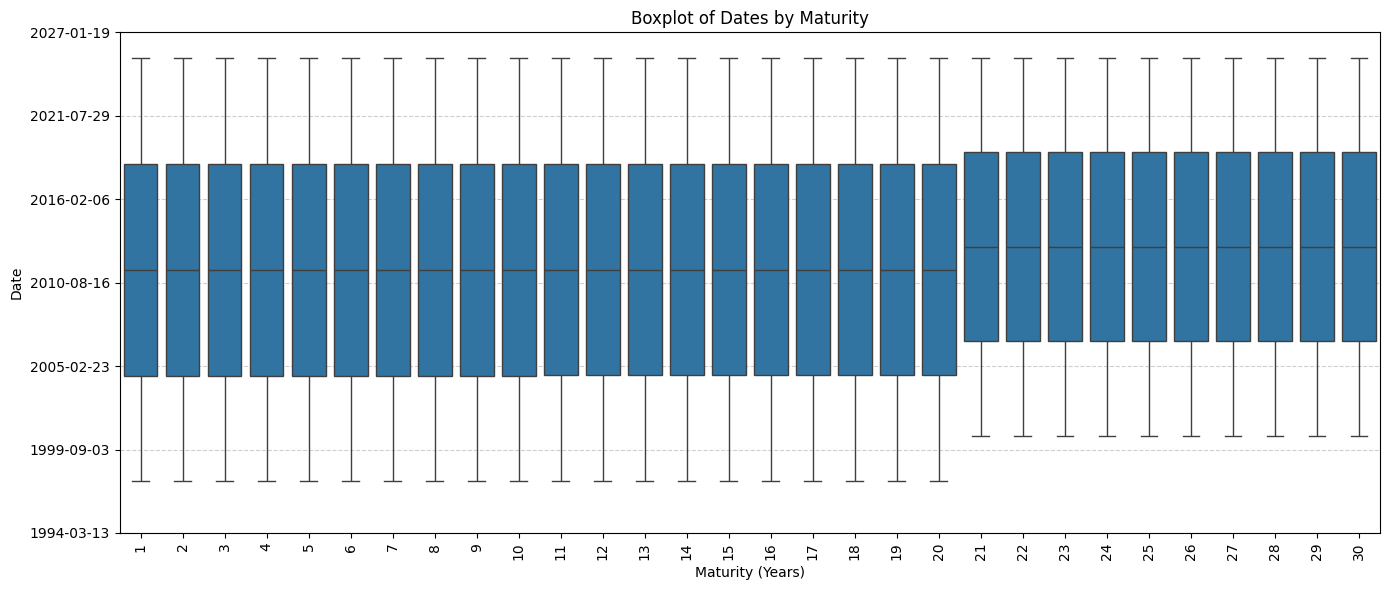

In [203]:
print("#-------------------------------------   OUTLIER ANALYSIS - Date Column -------------------------------------#")

# Prepare long-format date data for seaborn boxplot
date_long_df = []

for df in dataframes:
    file_name = df["FileReferenceName"].iloc[0]
    match = re.search(r"R(\d+)X", file_name)
    maturity = int(match.group(1)) if match else None

    for date in df["Date"].dropna():
        date_long_df.append({"Maturity": maturity, "Date": date})

# Create DataFrame
df_plot_date = pd.DataFrame(date_long_df)

# Convert datetime to ordinal for boxplot
df_plot_date["DateOrdinal"] = df_plot_date["Date"].map(pd.Timestamp.toordinal)

# Create the boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_plot_date, x="Maturity", y="DateOrdinal", showfliers=False)
plt.title("Boxplot of Dates by Maturity")
plt.xlabel("Maturity (Years)")
plt.ylabel("Date")
plt.xticks(rotation=90)
plt.grid(True, axis="y", linestyle="--", alpha=0.6)

# Format y-axis back from ordinal to readable dates
locs, labels = plt.yticks()
plt.yticks(ticks=locs, labels=[pd.Timestamp.fromordinal(int(d)).strftime('%Y-%m-%d') for d in locs])

plt.tight_layout()
plt.show()


#### **Interest Rate Column**

-------------------------------------- OUTLIER ANALYSIS - Interest Rate Column ---------------------------------------


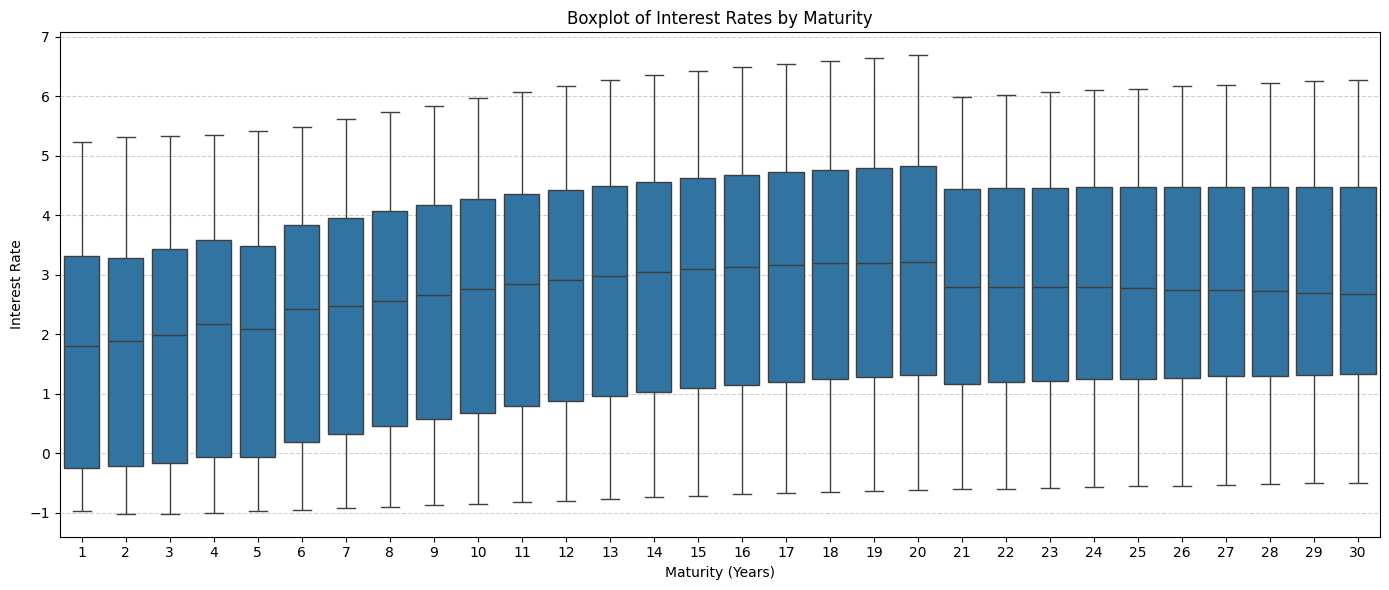

In [204]:
print("-------------------------------------- OUTLIER ANALYSIS - Interest Rate Column ---------------------------------------")

# Collect interest rate data
ir_long_df = []

outlier_counts_iqr = {}
outlier_counts_z = {}

for df in dataframes:
    file_name = df["FileReferenceName"].iloc[0]
    match = re.search(r"R(\d+)X", file_name)
    maturity = int(match.group(1)) if match else None

    series = df["Interest Rate"].dropna()
    if len(series) < 10:
        continue

    # Append to long-format DataFrame list
    ir_long_df.extend([{"Maturity": maturity, "Interest Rate": val} for val in series])

    # IQR outliers
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers_iqr = series[(series < lower) | (series > upper)]
    outlier_counts_iqr[maturity] = len(outliers_iqr)

    # Z-score outliers
    z_scores = zscore(series)
    outliers_z = series[(z_scores > 3) | (z_scores < -3)]
    outlier_counts_z[maturity] = len(outliers_z)

# Convert long-format data
df_plot_ir = pd.DataFrame(ir_long_df)

# Create boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_plot_ir, x="Maturity", y="Interest Rate", showfliers=True)
plt.title("Boxplot of Interest Rates by Maturity")
plt.xlabel("Maturity (Years)")
plt.ylabel("Interest Rate")
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


# #--------------------- Outlier Summary: IQR & Z-Score ---------------------#
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Create summary DataFrame
# outlier_summary_df = pd.DataFrame({
#     "Maturity": list(outlier_counts_iqr.keys()),
#     "Total Outliers (IQR)": list(outlier_counts_iqr.values()),
#     "Total Outliers (Z-Score)": [outlier_counts_z.get(k, 0) for k in outlier_counts_iqr.keys()]
# }).sort_values("Maturity").set_index("Maturity")

# print("#--------------------- Outlier Summary: Interest Rate ---------------------#")
# from IPython.display import display
# display(outlier_summary_df)

# # Plot histogram
# plt.figure(figsize=(12, 5))
# sns.barplot(x=outlier_summary_df.index, y=outlier_summary_df["Total Outliers (IQR)"], palette="coolwarm")
# plt.title("Outliers in Interest Rates (IQR Method)")
# plt.xlabel("Maturity")
# plt.ylabel("Outlier Count")
# plt.grid(True, axis='y', linestyle='--', alpha=0.6)
# plt.tight_layout()
# plt.show()



In [205]:
#--------------------- Data Availability Heatmap by Maturity and Month ---------------------#

# Prepare date range covering all files
all_dates = pd.date_range(
    start=min(df['Date'].min() for df in dataframes),
    end=max(df['Date'].max() for df in dataframes),
    freq='B'  # Business days only
)

# Initialize empty DataFrame with dates as index
heatmap_df = pd.DataFrame(index=all_dates)

# Populate matrix with availability per maturity (1 = data present, 0 = missing)
for df in dataframes:
    maturity = df["Maturity"].iloc[0]
    temp = df[['Date', 'Interest Rate']].copy()
    temp['HasData'] = temp['Interest Rate'].notna().astype(int)
    temp.set_index('Date', inplace=True)
    temp = temp.reindex(all_dates, fill_value=0)
    heatmap_df[maturity] = temp['HasData']

# Reorder rows by maturity
heatmap_df = heatmap_df.T.sort_index()

# Format ticks for two per year
xtick_positions = range(0, len(heatmap_df.columns), int(len(heatmap_df.columns) / ((2025 - 1997 + 1) * 2)))
xtick_labels = [heatmap_df.columns[i].strftime('%Y-%m') for i in xtick_positions]

# Plot heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(heatmap_df, cmap='viridis', cbar_kws={'label': 'Data Present (1) / Missing (0)'})
plt.title('Data Availability Heatmap by Maturity and Business Day')
plt.xlabel('Date')
plt.ylabel('Maturity (Years)')
plt.xticks(ticks=xtick_positions, labels=xtick_labels, rotation=45)
plt.tight_layout()
plt.show()


We can see from the above that for maturities 20-21 until 30 theyears 1997-1999 are not present. This will not be analysed now,however will also not be removed as this may r=present valuable information for the modeling.

### **<font color='#474747'>*1.2.3 - Data Quality Checks*</font>**

In [213]:
print("----------------------------------------- DATA QUALITY CHECKS - per File  ---------------------------------------")

quality_checks = []

for df in dataframes:
    file_name = df["FileReferenceName"].iloc[0]
    maturity = df["Maturity"].iloc[0]  # Use the actual numeric Maturity column directly

    # Basic checks
    is_sorted = df["Date"].is_monotonic_increasing
    duplicate_rows = df.duplicated().sum()
    duplicate_dates = df["Date"].duplicated().sum()
    missing_counts = df.isnull().sum()
    total_missing = missing_counts.sum()

    # Negative or zero interest rate values
    ir_col = "Interest Rate"
    if ir_col in df.columns:
        negative_or_zero = (df[ir_col] <= 0).sum()
    else:
        negative_or_zero = None

    quality_checks.append({
        "Maturity": maturity,
        "File Name": file_name,
        "Dates Sorted?": is_sorted,
        "Duplicate Rows": duplicate_rows,
        "Duplicate Dates": duplicate_dates,
        "Missing in 'Date'": missing_counts.get("Date", 0),
        "Missing in 'Interest Rate'": missing_counts.get("Interest Rate", 0),
        "Negative/Zero Interest Rates": negative_or_zero
    })

# Create DataFrame
quality_df = pd.DataFrame(quality_checks)
quality_df.set_index("Maturity", inplace=True)
quality_df = quality_df.sort_index()

# Display summary
from IPython.display import display
display(quality_df)

print("\n**Data Quality Check Complete!**\n")


----------------------------------------- DATA QUALITY CHECKS - per File  ---------------------------------------


File Name  Dates Sorted?  \
Maturity                                                                     
0.5       daily-term-structure-spot-interest-rate-R005X.csv           True   
1.0       daily-term-structure-spot-interest-rate-R01XX.csv           True   
2.0       daily-term-structure-spot-interest-rate-R02XX.csv           True   
3.0       daily-term-structure-spot-interest-rate-R03XX.csv           True   
4.0       daily-term-structure-spot-interest-rate-R04XX.csv           True   
5.0       daily-term-structure-spot-interest-rate-R05XX.csv           True   
6.0       daily-term-structure-spot-interest-rate-R06XX.csv           True   
7.0       daily-term-structure-spot-interest-rate-R07XX.csv           True   
8.0       daily-term-structure-spot-interest-rate-R08XX.csv           True   
9.0       daily-term-structure-spot-interest-rate-R09XX.csv           True   
10.0      daily-term-structure-spot-interest-rate-R10XX.csv           True   
11.0      daily-term-structure-spot-interest-rate-R11XX.csv           True   
12.0      daily-term-structure-spot-interest-rate-R12XX.csv           True   
13.0      daily-term-structure-spot-interest-rate-R13XX.csv           True   
14.0      daily-term-structure-spot-interest-rate-R14XX.csv           True   
15.0      daily-term-structure-spot-interest-rate-R15XX.csv           True   
16.0      daily-term-structure-spot-interest-rate-R16XX.csv           True   
17.0      daily-term-structure-spot-interest-rate-R17XX.csv           True   
18.0      daily-term-structure-spot-interest-rate-R18XX.csv           True   
19.0      daily-term-structure-spot-interest-rate-R19XX.csv           True   
20.0      daily-term-structure-spot-interest-rate-R20XX.csv           True   
21.0      daily-term-structure-spot-interest-rate-R21XX.csv           True   
22.0      daily-term-structure-spot-interest-rate-R22XX.csv           True   
23.0      daily-term-structure-spot-interest-rate-R23XX.csv           True   
24.0      daily-term-structure-spot-interest-rate-R24XX.csv           True   
25.0      daily-term-structure-spot-interest-rate-R25XX.csv           True   
26.0      daily-term-structure-spot-interest-rate-R26XX.csv           True   
27.0      daily-term-structure-spot-interest-rate-R27XX.csv           True   
28.0      daily-term-structure-spot-interest-rate-R28XX.csv           True   
29.0      daily-term-structure-spot-interest-rate-R29XX.csv           True   
30.0      daily-term-structure-spot-interest-rate-R30XX.csv           True   

          Duplicate Rows  Duplicate Dates  Missing in 'Date'  \
Maturity                                                       
0.5                    0                0                  0   
1.0                    0                0                  0   
2.0                    0                0                  0   
3.0                    0                0                  0   
4.0                    0                0                  0   
5.0                    0                0                  0   
6.0                    0                0                  0   
7.0                    0                0                  0   
8.0                    0                0                  0   
9.0                    0                0                  0   
10.0                   0                0                  0   
11.0                   0                0                  0   
12.0                   0                0                  0   
13.0                   0                0                  0   
14.0                   0                0                  0   
15.0                   0                0                  0   
16.0                   0                0                  0   
17.0                   0                0                  0   
18.0                   0                0                  0   
19.0                   0                0                  0   
20.0                   0                0                  0   
21.


**Data Quality Check Complete!**



### **<font color='#474747'>*1.2.4 - Missing Values Per XXX*</font>**


##### **1.2.4.1 - Missing Values - Per Day of Week**
* Count
* Percentage

In [207]:
print("#------------------------------   MISSING VALUES - Per Working Day and Weekend ---------------#")
# Dictionaries to hold results
counts = []
percentages = []

for df in dataframes:
    file_name = df["FileReferenceName"].iloc[0]
    match = re.search(r"R(\d+)X", file_name)
    maturity = int(match.group(1)) if match else file_name

    # Filter valid date rows and create weekday column
    df = df[df["Date"].notnull()].copy()
    df["Weekday"] = df["Date"].dt.strftime("%A")

    # Count total per weekday
    total_counts = df["Weekday"].value_counts()

    # Count missing interest rates per weekday
    missing_counts = df[df["Interest Rate"].isnull()]["Weekday"].value_counts()

    row_counts = {"Maturity": maturity}
    row_percentages = {"Maturity": maturity}

    for day in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]:
        total = total_counts.get(day, 0)
        missing = missing_counts.get(day, 0)
        row_counts[day] = missing
        row_percentages[day] = round((missing / total * 100), 2) if total > 0 else None

    counts.append(row_counts)
    percentages.append(row_percentages)

# Convert to DataFrames
missing_counts_df = pd.DataFrame(counts).set_index("Maturity").sort_index()
missing_percent_df = pd.DataFrame(percentages).set_index("Maturity").sort_index()

# Display both
print("Missing Interest Rate Counts by Weekday:")
display(missing_counts_df)

print("Percentage Missing Interest Rates by Weekday:")
display(missing_percent_df)



#------------------------------   MISSING VALUES - Per Working Day and Weekend ---------------#
Missing Interest Rate Counts by Weekday:


Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
Maturity                                                                
1             64       28         26        29      55      1450    1450
2             64       28         26        29      55      1450    1450
3             64       28         26        29      55      1450    1450
4             64       28         26        29      55      1450    1450
5             64       28         26        29      55      1450    1450
5             64       28         26        29      55      1450    1450
6             64       28         26        29      55      1450    1450
7             64       28         26        29      55      1450    1450
8             64       28         26        29      55      1450    1450
9             64       28         26        29      55      1450    1450
10            64       28         26        29      55      1450    1450
11            64       28         26        29      54      1450    1450
12            64       28         26        29      54      1450    1450
13            64       28         26        29      54      1450    1450
14            64       28         26        29      54      1450    1450
15            64       28         26        29      54      1450    1450
16            64       28         26        29      54      1450    1450
17            64       28         26        29      54      1450    1450
18            64       28         26        29      54      1450    1450
19            64       28         26        29      54      1450    1450
20            64       28         26        29      54      1450    1450
21            57       27         23        21      44      1293    1293
22            57       27         23        21      44      1293    1293
23            57       27         23        21      44      1293    1293
24            57       27         23        21      44      1293    1293
25            57       27         23        21      44      1293    1293
26            57       27         23        21      44      1293    1293
27            57       27         23        21      44      1293    1293
28            57       27         23        21      44      1293    1293
29            57       27         23        21      44      1293    1293
30            57       27         23        21      44      1293    1293

Percentage Missing Interest Rates by Weekday:


Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
Maturity                                                                
1           4.41     1.93       1.79      2.00    3.79     100.0   100.0
2           4.41     1.93       1.79      2.00    3.79     100.0   100.0
3           4.41     1.93       1.79      2.00    3.79     100.0   100.0
4           4.41     1.93       1.79      2.00    3.79     100.0   100.0
5           4.41     1.93       1.79      2.00    3.79     100.0   100.0
5           4.41     1.93       1.79      2.00    3.79     100.0   100.0
6           4.41     1.93       1.79      2.00    3.79     100.0   100.0
7           4.41     1.93       1.79      2.00    3.79     100.0   100.0
8           4.41     1.93       1.79      2.00    3.79     100.0   100.0
9           4.41     1.93       1.79      2.00    3.79     100.0   100.0
10          4.41     1.93       1.79      2.00    3.79     100.0   100.0
11          4.41     1.93       1.79      2.00    3.73     100.0   100.0
12          4.41     1.93       1.79      2.00    3.73     100.0   100.0
13          4.41     1.93       1.79      2.00    3.73     100.0   100.0
14          4.41     1.93       1.79      2.00    3.73     100.0   100.0
15          4.41     1.93       1.79      2.00    3.73     100.0   100.0
16          4.41     1.93       1.79      2.00    3.73     100.0   100.0
17          4.41     1.93       1.79      2.00    3.73     100.0   100.0
18          4.41     1.93       1.79      2.00    3.73     100.0   100.0
19          4.41     1.93       1.79      2.00    3.73     100.0   100.0
20          4.41     1.93       1.79      2.00    3.73     100.0   100.0
21          4.41     2.09       1.78      1.62    3.40     100.0   100.0
22          4.41     2.09       1.78      1.62    3.40     100.0   100.0
23          4.41     2.09       1.78      1.62    3.40     100.0   100.0
24          4.41     2.09       1.78      1.62    3.40     100.0   100.0
25          4.41     2.09       1.78      1.62    3.40     100.0   100.0
26          4.41     2.09       1.78      1.62    3.40     100.0   100.0
27          4.41     2.09       1.78      1.62    3.40     100.0   100.0
28          4.41     2.09       1.78      1.62    3.40     100.0   100.0
29          4.41     2.09       1.78      1.62    3.40     100.0   100.0
30          4.41     2.09       1.78      1.62    3.40     100.0   100.0

###### **1.2.4.2.a - Heatmap Missing Values**

#------------------------------   HEATMAP MISSING VALUES - Per Work Day and Weekend  ---------------#


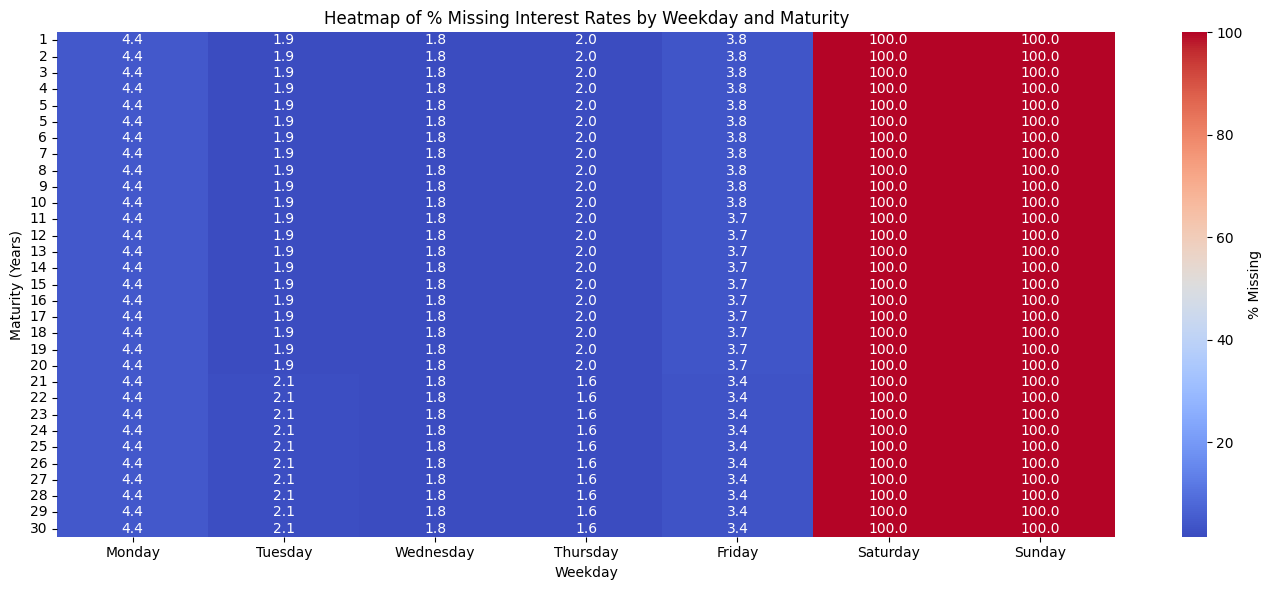

In [208]:
print("#------------------------------   HEATMAP MISSING VALUES - Per Work Day and Weekend  ---------------#")
# Reorder weekday columns for better readability
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
heatmap_data = missing_percent_df[weekday_order]

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={"label": "% Missing"})
plt.title("Heatmap of % Missing Interest Rates by Weekday and Maturity")
plt.xlabel("Weekday")
plt.ylabel("Maturity (Years)")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [145]:
#------------------------------   HEATMAP MISSING VALUES - Per Month and Maturity ---------------#
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Calculate % missing Interest Rate per month and maturity
monthly_missing_summary = []

for df in dataframes:
    file_name = df["FileReferenceName"].iloc[0]
    match = re.search(r"R(\d+)X", file_name)
    maturity = int(match.group(1)) if match else file_name

    df = df[df["Date"].notnull()].copy()
    df["Month"] = df["Date"].dt.strftime("%B")

    total_counts = df["Month"].value_counts()
    missing_counts = df[df["Interest Rate"].isnull()]["Month"].value_counts()

    row = {"Maturity": maturity}
    for month in [
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ]:
        total = total_counts.get(month, 0)
        missing = missing_counts.get(month, 0)
        row[month] = round((missing / total * 100), 2) if total > 0 else 0

    monthly_missing_summary.append(row)

# Create DataFrame
missing_month_df = pd.DataFrame(monthly_missing_summary).set_index("Maturity").sort_index()

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(missing_month_df, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={"label": "% Missing"})
plt.title("Heatmap of % Missing Interest Rates by Month and Maturity")
plt.xlabel("Month")
plt.ylabel("Maturity (Years)")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


##### **1.2.4.2 - Missing Values - Per Month**
* Count
* Percentage

In [209]:
print("#------------------------------   MISSING VALUES - Per Month ---------------#")

# Storage for results
monthly_counts = []
monthly_percentages = []

for df in dataframes:
    file_name = df["FileReferenceName"].iloc[0]
    maturity = int(df["Maturity"].iloc[0])  # Use maturity from column

    # Ensure valid dates
    df = df[df["Date"].notnull()].copy()
    df["Month"] = df["Date"].dt.strftime("%B")

    # Count total and missing interest rates per month
    total_counts = df["Month"].value_counts()
    missing_counts = df[df["Interest Rate"].isnull()]["Month"].value_counts()

    row_counts = {"Maturity": maturity}
    row_percentages = {"Maturity": maturity}

    # Ensure consistent month order
    months = [
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ]

    for month in months:
        total = total_counts.get(month, 0)
        missing = missing_counts.get(month, 0)
        row_counts[month] = missing
        row_percentages[month] = round((missing / total * 100), 2) if total > 0 else None

    monthly_counts.append(row_counts)
    monthly_percentages.append(row_percentages)

# Create DataFrames
missing_month_counts_df = pd.DataFrame(monthly_counts).set_index("Maturity").sort_index()
missing_month_percent_df = pd.DataFrame(monthly_percentages).set_index("Maturity").sort_index()

# Display results
print("Missing Interest Rate Counts by Month:")
display(missing_month_counts_df)

print("Percentage Missing Interest Rates by Month:")
display(missing_month_percent_df)


#------------------------------   MISSING VALUES - Per Month ---------------#
Missing Interest Rate Counts by Month:


January  February  March  April  May  June  July  August  September  \
Maturity                                                                        
0             268       226    258    286  271   237   240     252        240   
1             268       226    258    286  271   237   240     252        240   
2             268       226    258    286  271   237   240     252        240   
3             268       226    258    286  271   237   240     252        240   
4             268       226    258    286  271   237   240     252        240   
5             268       226    258    286  271   237   240     252        240   
6             268       226    258    286  271   237   240     252        240   
7             268       226    258    286  271   237   240     252        240   
8             268       226    258    286  271   237   240     252        240   
9             268       226    258    286  271   237   240     252        240   
10            268       226    258    286  271   237   240     252        240   
11            268       226    258    286  271   237   240     251        240   
12            268       226    258    286  271   237   240     251        240   
13            268       226    258    286  271   237   240     251        240   
14            268       226    258    286  271   237   240     251        240   
15            268       226    258    286  271   237   240     251        240   
16            268       226    258    286  271   237   240     251        240   
17            268       226    258    286  271   237   240     251        240   
18            268       226    258    286  271   237   240     251        240   
19            268       226    258    286  271   237   240     251        240   
20            268       226    258    286  271   237   240     251        240   
21            237       202    233    254  238   210   213     219        216   
22            237       202    233    254  238   210   213     219        216   
23            237       202    233    254  238   210   213     219        216   
24            237       202    233    254  238   210   213     219        216   
25            237       202    233    254  238   210   213     219        216   
26            237       202    233    254  238   210   213     219        216   
27            237       202    233    254  238   210   213     219        216   
28            237       202    233    254  238   210   213     219        216   
29            237       202    233    254  238   210   213     219        216   
30            237       202    233    254  238   210   213     219        216   

          October  November  December  
Maturity                               
0             256       240       328  
1             256       240       328  
2             256       240       328  
3             256       240       328  
4             256       240       328  
5             256       240       328  
6             256       240       328  
7             256       240       328  
8             256       240       328  
9             256       240       328  
10            256       240       328  
11            256       240       328  
12            256       240       328  
13            256       240       328  
14            256       240       328  
15            256       240       328  
16            256       240       328  
17            256       240       328  
18            256       240       328  
19            256       240       328  
20            256       240       328  
21            228       213       295  
22            228       213       295  
23            228       213       295  
24            228       213       295  
25            228       213       295  
26            228       213       295  
27            228       213       295  
28            228       213       295  
29            228       213       295  
30            228       213       295

Percentage Missing Interest Rates by Month:


January  February  March  April    May   June   July  August  \
Maturity                                                                 
0           30.88     28.57  29.72  34.05  31.81  29.26  28.67   29.03   
1           30.88     28.57  29.72  34.05  31.81  29.26  28.67   29.03   
2           30.88     28.57  29.72  34.05  31.81  29.26  28.67   29.03   
3           30.88     28.57  29.72  34.05  31.81  29.26  28.67   29.03   
4           30.88     28.57  29.72  34.05  31.81  29.26  28.67   29.03   
5           30.88     28.57  29.72  34.05  31.81  29.26  28.67   29.03   
6           30.88     28.57  29.72  34.05  31.81  29.26  28.67   29.03   
7           30.88     28.57  29.72  34.05  31.81  29.26  28.67   29.03   
8           30.88     28.57  29.72  34.05  31.81  29.26  28.67   29.03   
9           30.88     28.57  29.72  34.05  31.81  29.26  28.67   29.03   
10          30.88     28.57  29.72  34.05  31.81  29.26  28.67   29.03   
11          30.88     28.57  29.72  34.05  31.81  29.26  28.67   28.95   
12          30.88     28.57  29.72  34.05  31.81  29.26  28.67   28.95   
13          30.88     28.57  29.72  34.05  31.81  29.26  28.67   28.95   
14          30.88     28.57  29.72  34.05  31.81  29.26  28.67   28.95   
15          30.88     28.57  29.72  34.05  31.81  29.26  28.67   28.95   
16          30.88     28.57  29.72  34.05  31.81  29.26  28.67   28.95   
17          30.88     28.57  29.72  34.05  31.81  29.26  28.67   28.95   
18          30.88     28.57  29.72  34.05  31.81  29.26  28.67   28.95   
19          30.88     28.57  29.72  34.05  31.81  29.26  28.67   28.95   
20          30.88     28.57  29.72  34.05  31.81  29.26  28.67   28.95   
21          30.58     28.61  30.06  33.87  31.36  29.17  28.63   28.29   
22          30.58     28.61  30.06  33.87  31.36  29.17  28.63   28.29   
23          30.58     28.61  30.06  33.87  31.36  29.17  28.63   28.29   
24          30.58     28.61  30.06  33.87  31.36  29.17  28.63   28.29   
25          30.58     28.61  30.06  33.87  31.36  29.17  28.63   28.29   
26          30.58     28.61  30.06  33.87  31.36  29.17  28.63   28.29   
27          30.58     28.61  30.06  33.87  31.36  29.17  28.63   28.29   
28          30.58     28.61  30.06  33.87  31.36  29.17  28.63   28.29   
29          30.58     28.61  30.06  33.87  31.36  29.17  28.63   28.29   
30          30.58     28.61  30.06  33.87  31.36  29.17  28.63   28.29   

          September  October  November  December  
Maturity                                          
0             28.57    29.49     28.57     37.79  
1             28.57    29.49     28.57     37.79  
2             28.57    29.49     28.57     37.79  
3             28.57    29.49     28.57     37.79  
4             28.57    29.49     28.57     37.79  
5             28.57    29.49     28.57     37.79  
6             28.57    29.49     28.57     37.79  
7             28.57    29.49     28.57     37.79  
8             28.57    29.49     28.57     37.79  
9             28.57    29.49     28.57     37.79  
10            28.57    29.49     28.57     37.79  
11            28.57    29.49     28.57     37.79  
12            28.57    29.49     28.57     37.79  
13            28.57    29.49     28.57     37.79  
14            28.57    29.49     28.57     37.79  
15            28.57    29.49     28.57     37.79  
16            28.57    29.49     28.57     37.79  
17            28.57    29.49     28.57     37.79  
18            28.57    29.49     28.57     37.79  
19            28.57    29.49     28.57     37.79  
20            28.57    29.49     28.57     37.79  
21            28.80    29.42     28.40     38.06  
22            28.80    29.42     28.40     38.06  
23            28.80    29.42     28.40     38.06  
24            28.80    29.42     28.40     38.06  
25            28.80    29.42     28.40     38.06  
26            28.80    29.42     28.40     38.06  
27            28.80    29.42     28.40     38.06  
28            28.80    29.42     28.4

###### **1.2.4.2.a - Heatmap Missing Values**

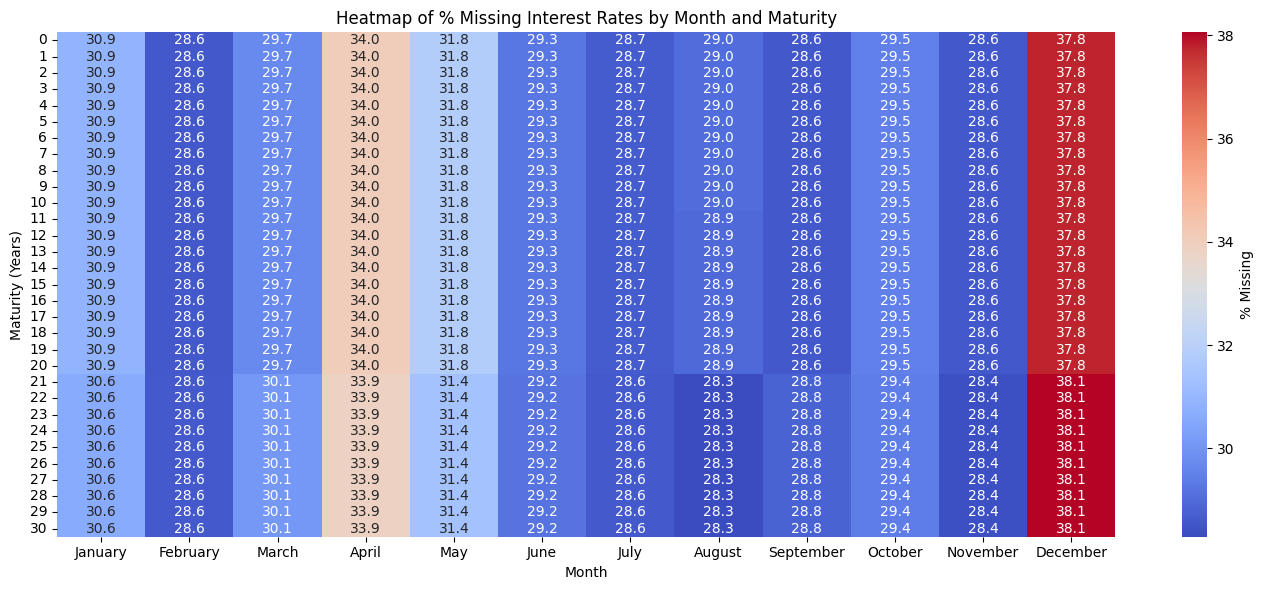

In [210]:

# Reorder month columns for better readability
month_order = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

# Filter and reorder the columns in the percentage DataFrame
heatmap_data_month = missing_month_percent_df[month_order]

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data_month, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={"label": "% Missing"})
plt.title("Heatmap of % Missing Interest Rates by Month and Maturity")
plt.xlabel("Month")
plt.ylabel("Maturity (Years)")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


##### **1.2.4.3 - Missing Values - Per YYYY-MM**
* Count
* Percentage

Missing Interest Rate Counts by YYYY-MM:


1997-08  1997-09  1997-10  1997-11  1997-12  1998-01  1998-02  \
Maturity                                                                  
0            14.0      8.0      9.0     10.0     12.0     10.0      8.0   
1            14.0      8.0      9.0     10.0     12.0     10.0      8.0   
2            14.0      8.0      9.0     10.0     12.0     10.0      8.0   
3            14.0      8.0      9.0     10.0     12.0     10.0      8.0   
4            14.0      8.0      9.0     10.0     12.0     10.0      8.0   
5            14.0      8.0      9.0     10.0     12.0     10.0      8.0   
6            14.0      8.0      9.0     10.0     12.0     10.0      8.0   
7            14.0      8.0      9.0     10.0     12.0     10.0      8.0   
8            14.0      8.0      9.0     10.0     12.0     10.0      8.0   
9            14.0      8.0      9.0     10.0     12.0     10.0      8.0   
10           14.0      8.0      9.0     10.0     12.0     10.0      8.0   
11           13.0      8.0      9.0     10.0     12.0     10.0      8.0   
12           13.0      8.0      9.0     10.0     12.0     10.0      8.0   
13           13.0      8.0      9.0     10.0     12.0     10.0      8.0   
14           13.0      8.0      9.0     10.0     12.0     10.0      8.0   
15           13.0      8.0      9.0     10.0     12.0     10.0      8.0   
16           13.0      8.0      9.0     10.0     12.0     10.0      8.0   
17           13.0      8.0      9.0     10.0     12.0     10.0      8.0   
18           13.0      8.0      9.0     10.0     12.0     10.0      8.0   
19           13.0      8.0      9.0     10.0     12.0     10.0      8.0   
20           13.0      8.0      9.0     10.0     12.0     10.0      8.0   
21            NaN      NaN      NaN      NaN      NaN      NaN      NaN   
22            NaN      NaN      NaN      NaN      NaN      NaN      NaN   
23            NaN      NaN      NaN      NaN      NaN      NaN      NaN   
24            NaN      NaN      NaN      NaN      NaN      NaN      NaN   
25            NaN      NaN      NaN      NaN      NaN      NaN      NaN   
26            NaN      NaN      NaN      NaN      NaN      NaN      NaN   
27            NaN      NaN      NaN      NaN      NaN      NaN      NaN   
28            NaN      NaN      NaN      NaN      NaN      NaN      NaN   
29            NaN      NaN      NaN      NaN      NaN      NaN      NaN   
30            NaN      NaN      NaN      NaN      NaN      NaN      NaN   

          1998-03  1998-04  1998-05  ...  2024-08  2024-09  2024-10  2024-11  \
Maturity                             ...                                       
0             9.0     10.0     12.0  ...        9        9        8        9   
1             9.0     10.0     12.0  ...        9        9        8        9   
2             9.0     10.0     12.0  ...        9        9        8        9   
3             9.0     10.0     12.0  ...        9        9        8        9   
4             9.0     10.0     12.0  ...        9        9        8        9   
5             9.0     10.0     12.0  ...        9        9        8        9   
6             9.0     10.0     12.0  ...        9        9        8        9   
7             9.0     10.0     12.0  ...        9        9        8        9   
8             9.0     10.0     12.0  ...        9        9        8        9   
9             9.0     10.0     12.0  ...        9        9        8        9   
10            9.0     10.0     12.0  ...        9        9        8        9   
11            9.0     10.0     12.0  ...        9        9        8        9   
12            9.0     10.0     12.0  ...        9        9        8        9   
13            9.0     10.0     12.0  ...        9        9        8        9   
14            9.0     10.0     12.0  ...        9        9        8        9   
15            9.0     10.0     12.0  ...        9        9        8        9   
16            9.0     10.0     12.0  ...        9        9        8        9   
17            

Percentage Missing Interest Rates by YYYY-MM:


1997-08  1997-09  1997-10  1997-11  1997-12  1998-01  1998-02  \
Maturity                                                                  
0           45.16    26.67    29.03    33.33    38.71    32.26    28.57   
1           45.16    26.67    29.03    33.33    38.71    32.26    28.57   
2           45.16    26.67    29.03    33.33    38.71    32.26    28.57   
3           45.16    26.67    29.03    33.33    38.71    32.26    28.57   
4           45.16    26.67    29.03    33.33    38.71    32.26    28.57   
5           45.16    26.67    29.03    33.33    38.71    32.26    28.57   
6           45.16    26.67    29.03    33.33    38.71    32.26    28.57   
7           45.16    26.67    29.03    33.33    38.71    32.26    28.57   
8           45.16    26.67    29.03    33.33    38.71    32.26    28.57   
9           45.16    26.67    29.03    33.33    38.71    32.26    28.57   
10          45.16    26.67    29.03    33.33    38.71    32.26    28.57   
11          43.33    26.67    29.03    33.33    38.71    32.26    28.57   
12          43.33    26.67    29.03    33.33    38.71    32.26    28.57   
13          43.33    26.67    29.03    33.33    38.71    32.26    28.57   
14          43.33    26.67    29.03    33.33    38.71    32.26    28.57   
15          43.33    26.67    29.03    33.33    38.71    32.26    28.57   
16          43.33    26.67    29.03    33.33    38.71    32.26    28.57   
17          43.33    26.67    29.03    33.33    38.71    32.26    28.57   
18          43.33    26.67    29.03    33.33    38.71    32.26    28.57   
19          43.33    26.67    29.03    33.33    38.71    32.26    28.57   
20          43.33    26.67    29.03    33.33    38.71    32.26    28.57   
21            NaN      NaN      NaN      NaN      NaN      NaN      NaN   
22            NaN      NaN      NaN      NaN      NaN      NaN      NaN   
23            NaN      NaN      NaN      NaN      NaN      NaN      NaN   
24            NaN      NaN      NaN      NaN      NaN      NaN      NaN   
25            NaN      NaN      NaN      NaN      NaN      NaN      NaN   
26            NaN      NaN      NaN      NaN      NaN      NaN      NaN   
27            NaN      NaN      NaN      NaN      NaN      NaN      NaN   
28            NaN      NaN      NaN      NaN      NaN      NaN      NaN   
29            NaN      NaN      NaN      NaN      NaN      NaN      NaN   
30            NaN      NaN      NaN      NaN      NaN      NaN      NaN   

          1998-03  1998-04  1998-05  ...  2024-08  2024-09  2024-10  2024-11  \
Maturity                             ...                                       
0           29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
1           29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
2           29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
3           29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
4           29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
5           29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
6           29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
7           29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
8           29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
9           29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
10          29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
11          29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
12          29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
13          29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
14          29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
15          29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
16          29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
17          29

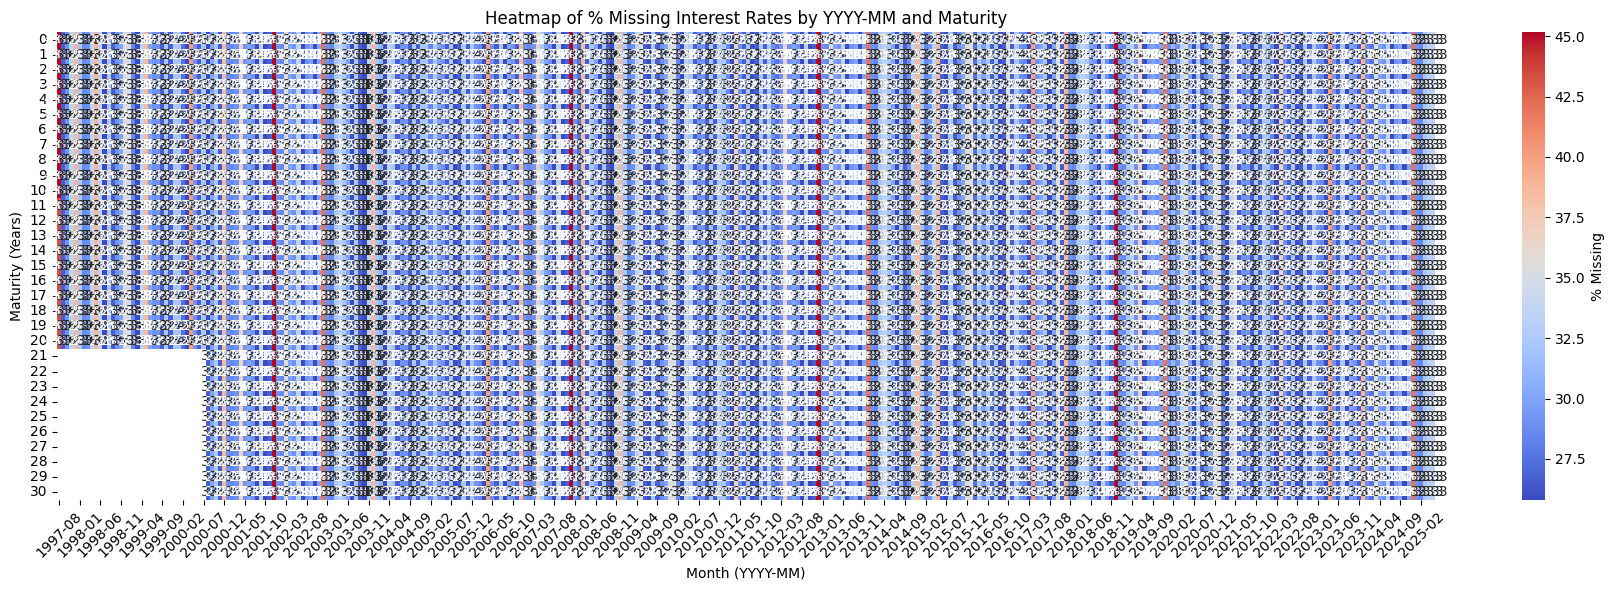

In [211]:
#------------------------------   MISSING VALUES - Per YYYY-MM ---------------#
# Storage for results
monthly_counts = []
monthly_percentages = []

for df in dataframes:
    maturity = int(df["Maturity"].iloc[0])  # Extract maturity directly

    df = df[df["Date"].notnull()].copy()
    df["Month"] = df["Date"].dt.to_period("M").astype(str)  # Format as 'YYYY-MM'

    total_counts = df["Month"].value_counts()
    missing_counts = df[df["Interest Rate"].isnull()]["Month"].value_counts()

    row_counts = {"Maturity": maturity}
    row_percentages = {"Maturity": maturity}

    for month in sorted(total_counts.index):  # Ensure sorted months
        total = total_counts.get(month, 0)
        missing = missing_counts.get(month, 0)
        row_counts[month] = missing
        row_percentages[month] = round((missing / total * 100), 2) if total > 0 else None

    monthly_counts.append(row_counts)
    monthly_percentages.append(row_percentages)

# Create DataFrames
missing_month_counts_df = pd.DataFrame(monthly_counts).set_index("Maturity").sort_index()
missing_month_percent_df = pd.DataFrame(monthly_percentages).set_index("Maturity").sort_index()

# Display results
print("Missing Interest Rate Counts by YYYY-MM:")
display(missing_month_counts_df)

print("Percentage Missing Interest Rates by YYYY-MM:")
display(missing_month_percent_df)

###### **1.2.4.3.a - Heatmap Missing Values**

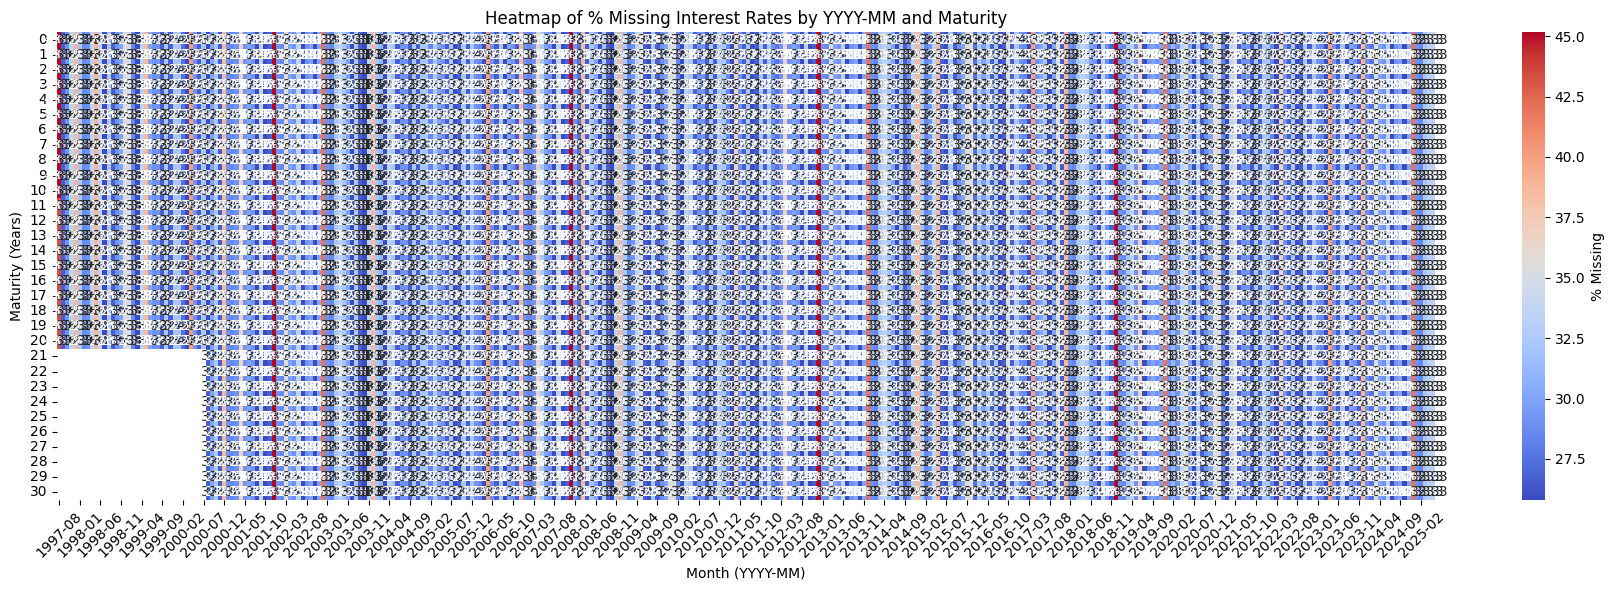

In [212]:
#------------------------------   HEATMAP OF % MISSING - Per YYYY-MM ---------------#
# Ensure columns are sorted chronologically
heatmap_data_ym = missing_month_percent_df.copy()
heatmap_data_ym = heatmap_data_ym[sorted(heatmap_data_ym.columns)]

# Plot heatmap
plt.figure(figsize=(18, 6))
sns.heatmap(heatmap_data_ym, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={"label": "% Missing"})
plt.title("Heatmap of % Missing Interest Rates by YYYY-MM and Maturity")
plt.xlabel("Month (YYYY-MM)")
plt.ylabel("Maturity (Years)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### **<font color='#474747'>*1.2.5 - Missing Values Per day of Week (Excluding Public Holidays)*</font>**
* Count
* Percentage

In [115]:
print("#-------------------------------------   MISSING DATA - Per Weekday (Excluding Public Holidays) -------------------------------------#")
# ------------------------- Generate TARGET2 Holidays -----------------------
class TARGET2HolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday("New Year's Day", month=1, day=1),
        GoodFriday,
        EasterMonday,
        Holiday("Labour Day", month=5, day=1),
        Holiday("Christmas Eve", month=12, day=24),
        Holiday("Christmas Day", month=12, day=25),
        Holiday("Boxing Day", month=12, day=26),
        Holiday("New Year's Eve", month=12, day=31),
    ]

holidays = TARGET2HolidayCalendar().holidays(start="1997-01-01", end="2025-12-31")

# ------------------------- Count Missing by Weekday (Excl. Holidays) -----------------------
counts = []
percentages = []

for df in dataframes:
    file_name = df["FileReferenceName"].iloc[0]
    match = re.search(r"R(\d+)X", file_name)
    maturity = int(match.group(1)) if match else file_name

    df = df[df["Date"].notnull()].copy()
    df = df[~df["Date"].isin(holidays)].copy()
    df["Weekday"] = df["Date"].dt.strftime("%A")

    total_counts = df["Weekday"].value_counts()
    missing_counts = df[df["Interest Rate"].isnull()]["Weekday"].value_counts()

    row_counts = {"Maturity": maturity}
    row_percentages = {"Maturity": maturity}

    for day in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]:
        total = total_counts.get(day, 0)
        missing = missing_counts.get(day, 0)
        row_counts[day] = missing
        row_percentages[day] = round((missing / total * 100), 2) if total > 0 else None

    counts.append(row_counts)
    percentages.append(row_percentages)

# Format results
missing_counts_df = pd.DataFrame(counts).set_index("Maturity").sort_index()
missing_percent_df = pd.DataFrame(percentages).set_index("Maturity").sort_index()

# ------------------------- Display -----------------------
print("#------------------------------   MISSING VALUES - Per Working Day (Excl. Holidays) ---------------#\n")
print("Missing Interest Rate Counts by Weekday:")
display(missing_counts_df)

print("Percentage Missing Interest Rates by Weekday:")
display(missing_percent_df)


#-------------------------------------   MISSING DATA - Per Weekday (Excluding Public Holidays) -------------------------------------#
#------------------------------   MISSING VALUES - Per Working Day (Excl. Holidays) ---------------#

Missing Interest Rate Counts by Weekday:


Monday  Tuesday  Wednesday  Thursday  Friday
Maturity                                              
1             12        4          2         5       3
2             12        4          2         5       3
3             12        4          2         5       3
4             12        4          2         5       3
5             12        4          2         5       3
5             12        4          2         5       3
6             12        4          2         5       3
7             12        4          2         5       3
8             12        4          2         5       3
9             12        4          2         5       3
10            12        4          2         5       3
11            12        4          2         5       2
12            12        4          2         5       2
13            12        4          2         5       2
14            12        4          2         5       2
15            12        4          2         5       2
16            12        4          2         5       2
17            12        4          2         5       2
18            12        4          2         5       2
19            12        4          2         5       2
20            12        4          2         5       2
21             9        3          1         1       1
22             9        3          1         1       1
23             9        3          1         1       1
24             9        3          1         1       1
25             9        3          1         1       1
26             9        3          1         1       1
27             9        3          1         1       1
28             9        3          1         1       1
29             9        3          1         1       1
30             9        3          1         1       1

Percentage Missing Interest Rates by Weekday:


Monday  Tuesday  Wednesday  Thursday  Friday
Maturity                                              
1           0.86     0.28       0.14      0.35    0.21
2           0.86     0.28       0.14      0.35    0.21
3           0.86     0.28       0.14      0.35    0.21
4           0.86     0.28       0.14      0.35    0.21
5           0.86     0.28       0.14      0.35    0.21
5           0.86     0.28       0.14      0.35    0.21
6           0.86     0.28       0.14      0.35    0.21
7           0.86     0.28       0.14      0.35    0.21
8           0.86     0.28       0.14      0.35    0.21
9           0.86     0.28       0.14      0.35    0.21
10          0.86     0.28       0.14      0.35    0.21
11          0.86     0.28       0.14      0.35    0.14
12          0.86     0.28       0.14      0.35    0.14
13          0.86     0.28       0.14      0.35    0.14
14          0.86     0.28       0.14      0.35    0.14
15          0.86     0.28       0.14      0.35    0.14
16          0.86     0.28       0.14      0.35    0.14
17          0.86     0.28       0.14      0.35    0.14
18          0.86     0.28       0.14      0.35    0.14
19          0.86     0.28       0.14      0.35    0.14
20          0.86     0.28       0.14      0.35    0.14
21          0.72     0.24       0.08      0.08    0.08
22          0.72     0.24       0.08      0.08    0.08
23          0.72     0.24       0.08      0.08    0.08
24          0.72     0.24       0.08      0.08    0.08
25          0.72     0.24       0.08      0.08    0.08
26          0.72     0.24       0.08      0.08    0.08
27          0.72     0.24       0.08      0.08    0.08
28          0.72     0.24       0.08      0.08    0.08
29          0.72     0.24       0.08      0.08    0.08
30          0.72     0.24       0.08      0.08    0.08

* Saturday & Sunday are always 100% missing
→ No rates published on weekends (normal).

* Weekday missingness is low (mostly ~1.6–4.4%)
→ These are likely holidays, system outages, or publication lags.





### Add code below - which counts the number of ir's missing (excluding weekends) (then public holidays)  

In [ ]:
# print("#-------------------------------------   MISSING DATA CHECKS - Interest Rate Column -------------------------------------#")
# ### INTEREST RATE COLUMN(S)
# # Prepare results list
# ir_analysis = []

# for df in dataframes:
#     # Extract numeric maturity value from filename (e.g., 5 from R005X)
#     file_name = df["FileReferenceName"].iloc[0]
#     match = re.search(r"R(\d+)X", file_name)
#     maturity = int(match.group(1)) if match else None

#     # Get interest rate column
#     ir_col = df["Interest Rate"]

#     # Basic statistics
#     min_ir = ir_col.min()
#     max_ir = ir_col.max()
#     ir_range = max_ir - min_ir if pd.notnull(min_ir) and pd.notnull(max_ir) else None
#     total_rows = len(df)
#     missing_count = ir_col.isnull().sum()
#     missing_pct = (missing_count / total_rows) * 100 if total_rows > 0 else 0

#     # Incorrectly formatted = non-null values that are not floats
#     incorrectly_formatted = ir_col.apply(lambda x: not isinstance(x, (float, int)) and pd.notnull(x)).sum()

#     ir_analysis.append({
#         "Maturity": maturity,
#         "Minimum Interest Rate": round(min_ir, 4) if pd.notnull(min_ir) else None,
#         "Maximum Interest Rate": round(max_ir, 4) if pd.notnull(max_ir) else None,
#         "Interest Rate Range": round(ir_range, 4) if ir_range is not None else None,
#         "Count Rows": total_rows,
#         "Count Missing Interest Rates": missing_count,
#         "% Missing Interest Rates": round(missing_pct, 2),
#         "Incorrectly Formatted Rates": incorrectly_formatted
#     })

# # Create summary DataFrame
# ir_summary_df = pd.DataFrame(ir_analysis)
# ir_summary_df.set_index("Maturity", inplace=True)
# ir_summary_df.sort_index(inplace=True)

# # Display the result
# print("Interest Rate Column Analysis by Maturity (Including Weekeends)")
# display(ir_summary_df)



## **<font color='#474747'>1.3 - Data Cleaning** - check
* Check:
- Public holidays
- Rules

### **<font color='#474747'>*1.3.1 - Apply Data Cleaning*</font>**
* Remove weekends completely
*  Forward-fill missing values (only on weekdays)
* Interpoalte remaning gaps because for yield curve modeling (e.g., Nelson-Siegel) - continuity is needed.

In [116]:
print("#-------------------------------------   DATA CLEANING - Apply Filling  -------------------------------------#")

from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, GoodFriday, EasterMonday

# Step 0: Define TARGET2 public holiday calendar
class TARGET2HolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday("New Year's Day", month=1, day=1),
        GoodFriday,
        EasterMonday,
        Holiday("Labour Day", month=5, day=1),
        Holiday("Christmas Eve", month=12, day=24),
        Holiday("Christmas Day", month=12, day=25),
        Holiday("Boxing Day", month=12, day=26),
        Holiday("New Year's Eve", month=12, day=31),
    ]

# Generate holidays from 1997 to 2025
holidays = TARGET2HolidayCalendar().holidays(start="1997-01-01", end="2025-12-31")

# Step-by-step data cleaning
for i, df in enumerate(dataframes):
    df = df.dropna(subset=["Date"]).copy()

    # Step 1: Remove weekends (Sat=5, Sun=6)
    df = df[~df["Date"].dt.weekday.isin([5, 6])]

    # Step 2: Remove TARGET2 holidays
    df = df[~df["Date"].isin(holidays)]

    # Step 3: Forward-fill up to 3 days
    df["Interest Rate"] = df["Interest Rate"].ffill(limit=3)

    # Step 4: Backward-fill up to 3 days
    df["Interest Rate"] = df["Interest Rate"].bfill(limit=3)

    # Step 5: Interpolate remaining gaps
    df["Interest Rate"] = df["Interest Rate"].interpolate(method="linear")

    # Step 6: Save cleaned DataFrame
    dataframes[i] = df


# # Final to tidy up and ensure the remianing gaps are filled
# for i, df in enumerate(dataframes):
#     df = df.dropna(subset=["Date"]).copy()
#     df = df[~df["Date"].dt.weekday.isin([5, 6])]
#     df = df[~df["Date"].isin(holidays)]

#     # Fill and interpolate
#     df["Interest Rate"] = df["Interest Rate"].ffill(limit=3)
#     df["Interest Rate"] = df["Interest Rate"].bfill(limit=3)
#     df["Interest Rate"] = df["Interest Rate"].interpolate(method="linear")

#     # Final sweep to remove edge NaNs
#     df["Interest Rate"] = df["Interest Rate"].ffill()
#     df["Interest Rate"] = df["Interest Rate"].bfill()

#     dataframes[i] = df
# print("#-------------------------------------   Completed  -------------------------------------#")

#-------------------------------------   DATA CLEANING - Apply Filling  -------------------------------------#
#-------------------------------------   Completed  -------------------------------------#



### **<font color='#474747'>*1.3.2 - Heatmap Missing Values*</font>**

#-------------------------------------   DATA CLEANING - Heatmap Check On Misisng Data -------------------------------------#


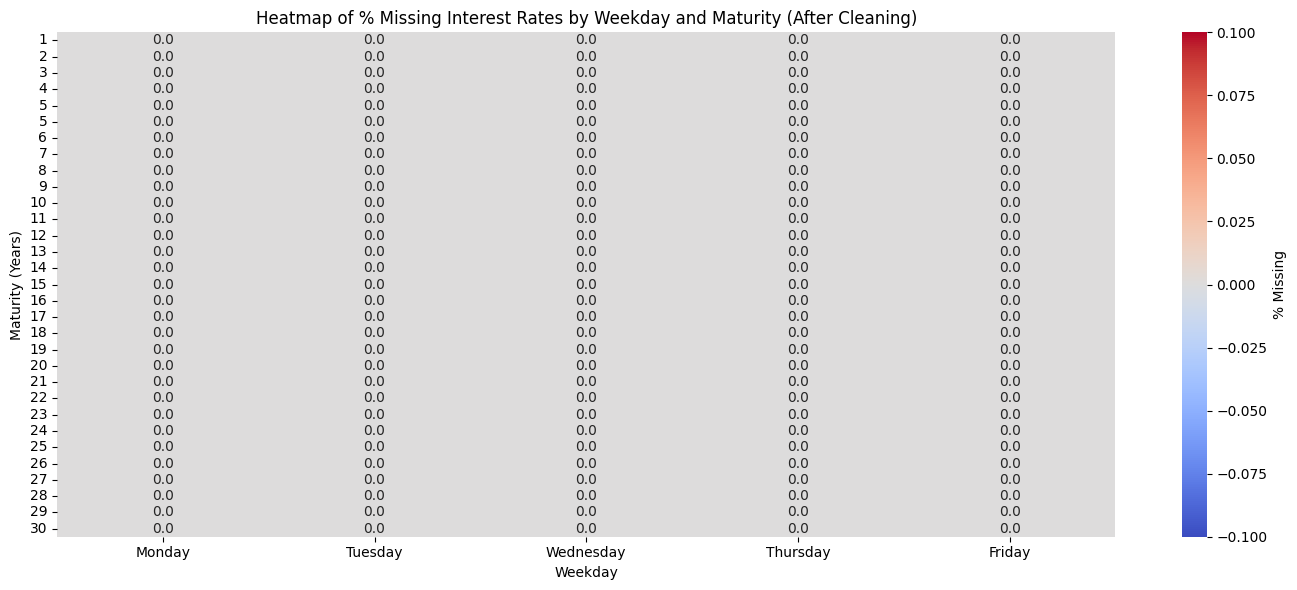


 Data is ready for exploration — no missing values remain.


In [117]:
print("#-------------------------------------   DATA CLEANING - Heatmap Check On Misisng Data -------------------------------------#")

# Recompute missing values by weekday after cleaning
counts = []
percentages = []

for df in dataframes:
    file_name = df["FileReferenceName"].iloc[0]
    match = re.search(r"R(\d+)X", file_name)
    maturity = int(match.group(1)) if match else file_name

    df = df[df["Date"].notnull()].copy()
    df["Weekday"] = df["Date"].dt.strftime("%A")
    df = df[~df["Weekday"].isin(["Saturday", "Sunday"])]

    total_counts = df["Weekday"].value_counts()
    missing_counts = df[df["Interest Rate"].isnull()]["Weekday"].value_counts()

    row_percentages = {"Maturity": maturity}
    for day in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]:
        total = total_counts.get(day, 0)
        missing = missing_counts.get(day, 0)
        row_percentages[day] = round((missing / total * 100), 2) if total > 0 else 0

    percentages.append(row_percentages)

# Create DataFrame
missing_percent_cleaned_df = pd.DataFrame(percentages).set_index("Maturity").sort_index()

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(missing_percent_cleaned_df, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={"label": "% Missing"})
plt.title("Heatmap of % Missing Interest Rates by Weekday and Maturity (After Cleaning)")
plt.xlabel("Weekday")
plt.ylabel("Maturity (Years)")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#  Print status message
if (missing_percent_cleaned_df.values == 0).all():
    print("\n Data is ready for exploration — no missing values remain.")
else:
    print("\n⚠ There are still missing values present — review needed.")


---
---
<br><br>
# **<font color='#000058'>Chapter 2: Data Exploration</font>**


### Next steps:

2. Data exploration: For each DataFrame, explore the data to understand its structure, including the number of rows and columns, data types of each column, descriptive statistics (mean, median, standard deviation, min, max) for numerical columns, and the presence of missing values. Also check for the date range covered in each file.

3. Data analysis: Analyze the relationships between different interest rates within each dataset and across datasets. Calculate correlations between different maturity rates. Look for trends and patterns in interest rate movements over time.

4. Data visualization: Create visualizations to represent the key findings. Visualize the time series of interest rates for different maturities. Show the correlation matrix between interest rates. Visualize any significant trends or patterns.

5. Finish task: Summarize the key characteristics of each dataset, highlighting any commonalities or differences across datasets. Present findings from the data exploration and analysis sections in a clear and concise manner, including the visualizations.

### **<font color='#474747'>*2.1.1 - Summary Statistics*</font>**

In [168]:
#--------------------- Summary Statistics of Cleaned Interest Rates by Maturity ---------------------#


# Store cleaned data and statistics
cleaned_dataframes = []
statistics = []

for df in dataframes:
    # Extract maturity label
    file_name = df["FileReferenceName"].iloc[0]
    match = re.search(r"R(\d+)X", file_name)
    maturity = int(match.group(1)) if match else file_name

    # Ensure column names match expected structure
    df_clean = df.dropna(subset=['Interest Rate']).copy()

    # Compute statistics
    stats = {
        'Maturity': maturity,
        'Count': df_clean['Interest Rate'].count(),
        'Mean': df_clean['Interest Rate'].mean(),
        'Median': df_clean['Interest Rate'].median(),
        'Std': df_clean['Interest Rate'].std(),
        'Min': df_clean['Interest Rate'].min(),
        'Max': df_clean['Interest Rate'].max()
    }

    cleaned_dataframes.append(df_clean)
    statistics.append(stats)

# Combine all statistics
stats_df = pd.DataFrame(statistics).sort_values("Maturity").set_index("Maturity")

# Display result
print("#--------------------- Summary Statistics of Cleaned Interest Rates by Maturity ---------------------")
display(stats_df)


#--------------------- Summary Statistics of Cleaned Interest Rates by Maturity ---------------------


Count      Mean  Median       Std   Min   Max
Maturity                                               
1          7048  1.564343   1.805  1.842042 -0.97  5.23
2          7048  1.661152   1.890  1.863627 -1.02  5.32
3          7048  1.781524   1.990  1.885157 -1.02  5.33
4          7048  1.914735   2.170  1.900096 -1.00  5.35
5          7048  1.520241   1.655  1.833644 -0.98  5.12
5          7048  2.051073   2.320  1.907814 -0.98  5.42
6          7048  2.184051   2.430  1.909892 -0.95  5.48
7          7048  2.309895   2.480  1.908469 -0.93  5.61
8          7048  2.426436   2.550  1.905424 -0.91  5.73
9          7048  2.532889   2.660  1.901973 -0.88  5.84
10         7048  2.629012   2.760  1.898492 -0.85  5.97
11         7048  2.715106   2.850  1.895801 -0.82  6.08
12         7048  2.791820   2.910  1.893829 -0.80  6.18
13         7048  2.859667   2.980  1.892588 -0.77  6.28
14         7048  2.919421   3.040  1.892116 -0.74  6.36
15         7048  2.971840   3.090  1.892460 -0.72  6.43
16         7048  3.017618   3.130  1.893271 -0.69  6.50
17         7048  3.057348   3.165  1.894763 -0.67  6.55
18         7048  3.091735   3.190  1.896570 -0.65  6.60
19         7048  3.121331   3.205  1.898811 -0.64  6.65
20         7048  3.146633   3.220  1.901452 -0.62  6.69
21         6295  2.876478   2.800  1.799655 -0.61  5.98
22         6295  2.892376   2.800  1.800189 -0.60  6.03
23         6295  2.905276   2.790  1.800864 -0.58  6.07
24         6295  2.915379   2.790  1.801611 -0.57  6.10
25         6295  2.923099   2.770  1.802371 -0.56  6.13
26         6295  2.928651   2.750  1.803262 -0.55  6.17
27         6295  2.932392   2.740  1.804320 -0.54  6.19
28         6295  2.934667   2.720  1.805407 -0.52  6.22
29         6295  2.935447   2.700  1.806725 -0.51  6.25
30         6295  2.935006   2.680  1.808107 -0.50  6.27

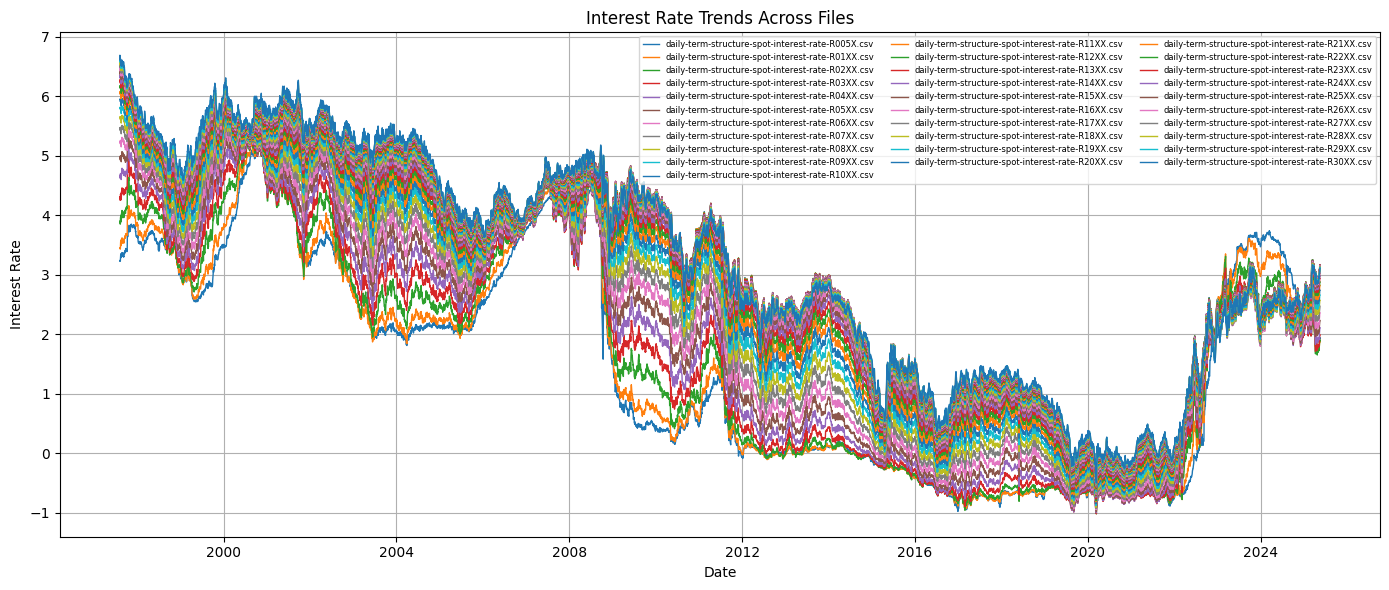

In [170]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
for i, df in enumerate(cleaned_dataframes):
    plt.plot(df['Date'], df['Interest Rate'], label=csv_files[i], linewidth=1)

plt.title('Interest Rate Trends Across Files')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.legend(loc='upper right', fontsize=6, ncol=3)
plt.grid(True)
plt.tight_layout()
plt.show()


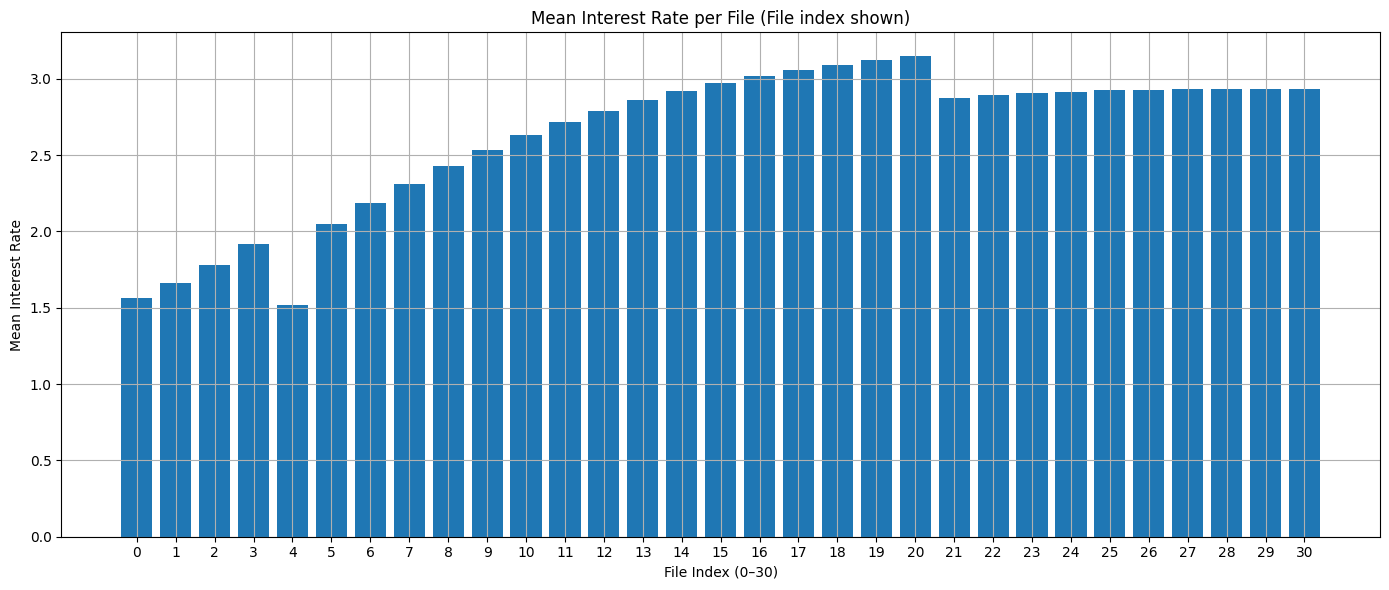

KeyError: 'Maturity'

In [173]:
# Add index numbers for x-axis
stats_df_sorted = stats_df_sorted.reset_index(drop=True)
plt.figure(figsize=(14, 6))
plt.bar(stats_df_sorted.index, stats_df_sorted['Mean'])

# Label the x-axis with index instead of full filenames
plt.xticks(stats_df_sorted.index, stats_df_sorted.index)
plt.title('Mean Interest Rate per File (File index shown)')
plt.xlabel('File Index (0–30)')
plt.ylabel('Mean Interest Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Print index-to-filename map
for i, file in enumerate(stats_df_sorted['File']):
    print(f"{i}: {file}")


In [174]:
summary = []

for i, df in enumerate(cleaned_dataframes):
    total_rows = len(df)
    valid = df['InterestRate'].notna().sum()
    missing = total_rows - valid
    missing_pct = (missing / total_rows) * 100

    start_date = df['Date'].min()
    end_date = df['Date'].max()
    duration_days = (end_date - start_date).days if pd.notnull(start_date) and pd.notnull(end_date) else None

    duplicate_dates = df['Date'].duplicated().sum()
    invalid_dates = df['Date'].isna().sum()

    summary.append({
        'File': csv_files[i],
        'Total Rows': total_rows,
        'Valid Entries': valid,
        'Missing (%)': round(missing_pct, 2),
        'Mean': df['InterestRate'].mean(),
        'Median': df['InterestRate'].median(),
        'Std': df['InterestRate'].std(),
        'Min': df['InterestRate'].min(),
        'Max': df['InterestRate'].max(),
        'Start Date': start_date,
        'End Date': end_date,
        'Date Coverage (days)': duration_days,
        'Duplicate Dates': duplicate_dates,
        'Invalid Dates (NaT)': invalid_dates,
    })

summary_df = pd.DataFrame(summary)

# Display the summary table
import seaborn as sns
from IPython.display import display
display(summary_df)


KeyError: 'InterestRate'

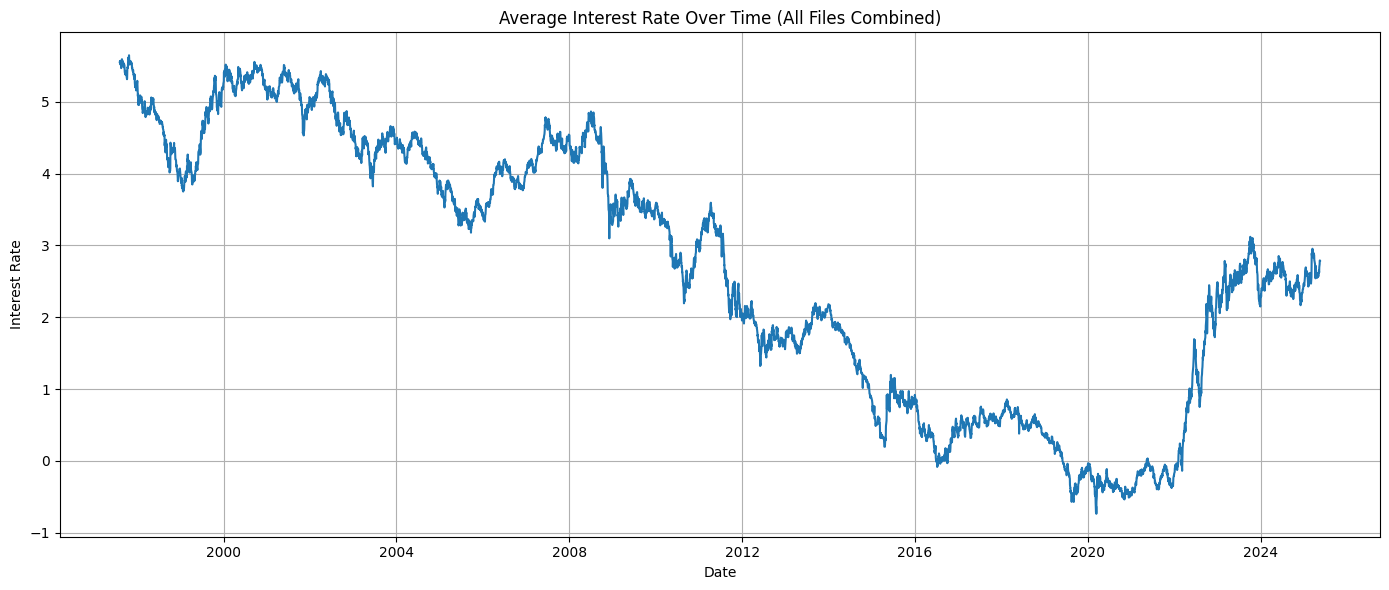

In [ ]:
# Combine all into one big DataFrame
combined_df = pd.concat(cleaned_dataframes, ignore_index=True)

# Group by date, calculate mean interest rate across files
daily_avg = combined_df.groupby('Date')['InterestRate'].mean().reset_index()

# Plot the aggregated trend
plt.figure(figsize=(14, 6))
plt.plot(daily_avg['Date'], daily_avg['InterestRate'], label='Average Interest Rate')
plt.title('Average Interest Rate Over Time (All Files Combined)')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

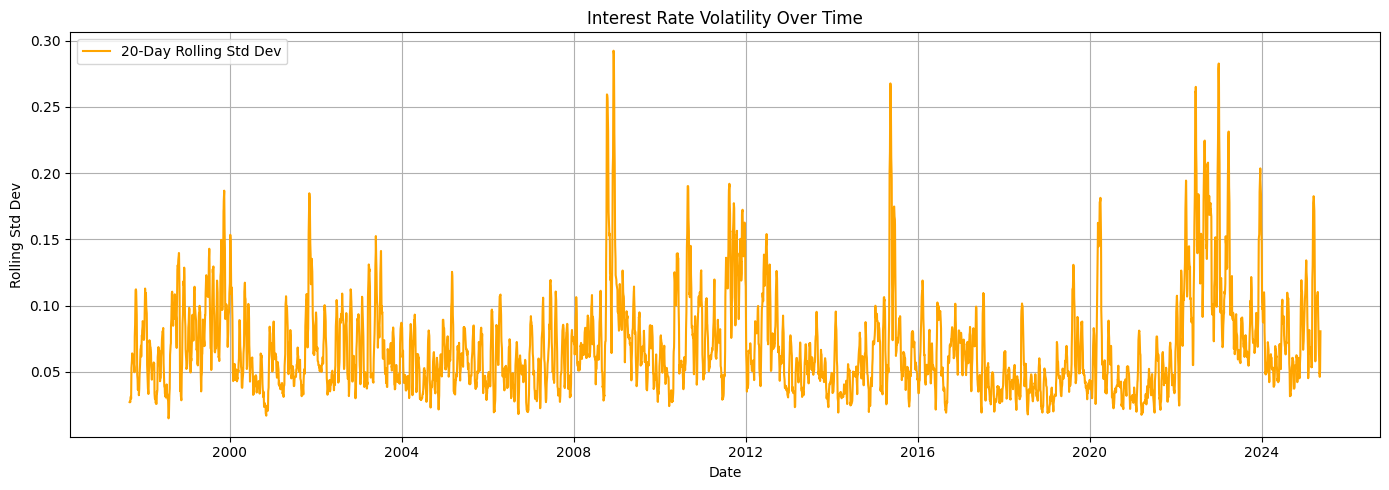

In [ ]:
# 20-day rolling standard deviation
daily_avg['RollingStd'] = daily_avg['InterestRate'].rolling(window=20).std()

plt.figure(figsize=(14, 5))
plt.plot(daily_avg['Date'], daily_avg['RollingStd'], color='orange', label='20-Day Rolling Std Dev')
plt.title('Interest Rate Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Rolling Std Dev')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

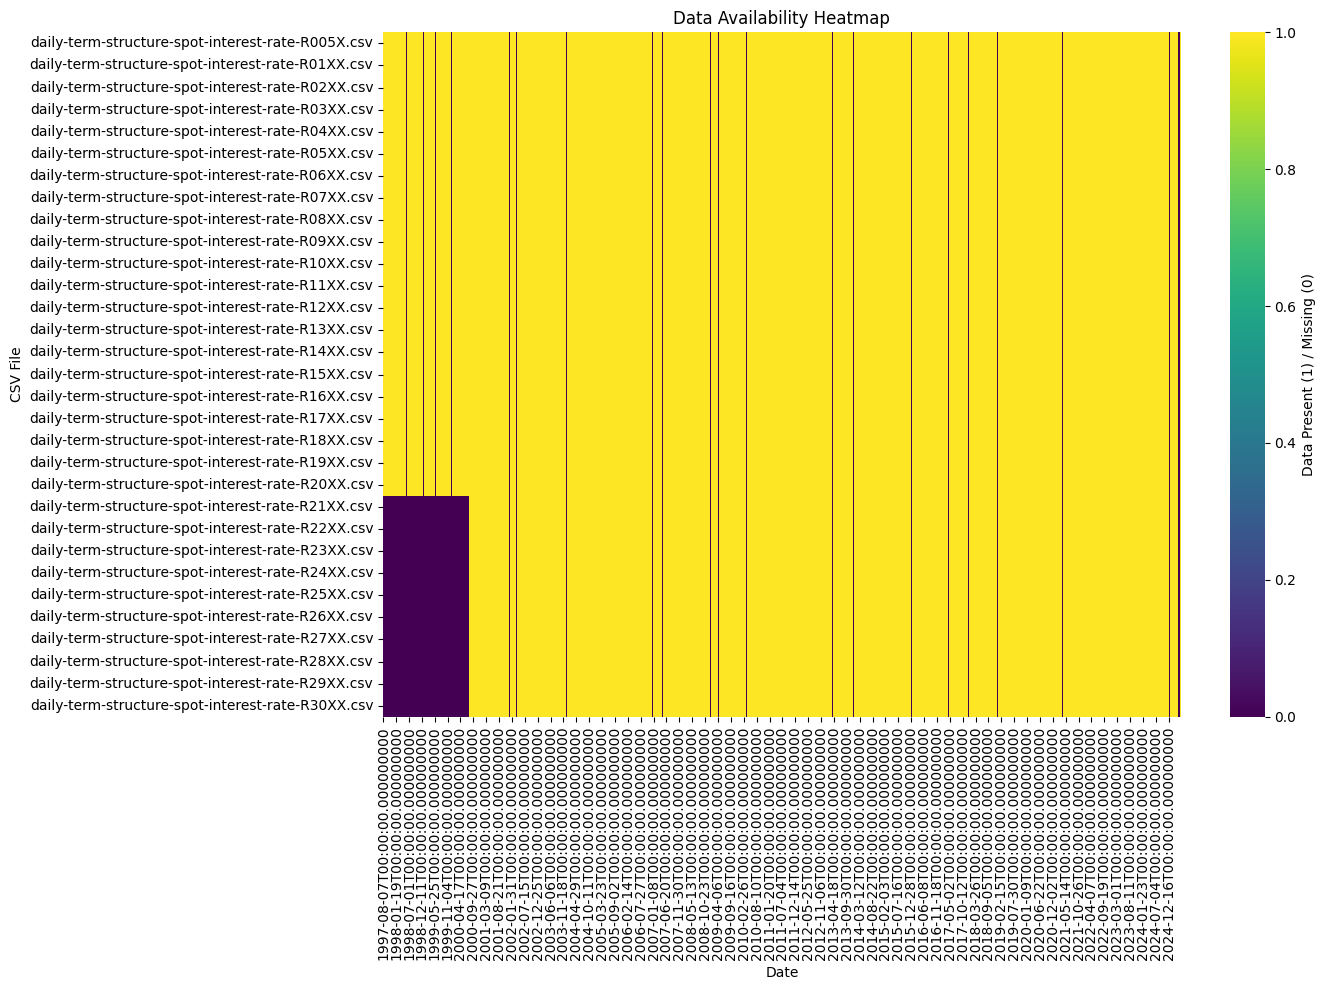

In [ ]:
# # Create a matrix of Date vs File with 1 = present, 0 = missing
# all_dates = pd.date_range(start=combined_df['Date'].min(), end=combined_df['Date'].max(), freq='B')
# heatmap_df = pd.DataFrame(index=all_dates)

# for i, df in enumerate(cleaned_dataframes):
#     temp = df[['Date', 'InterestRate']].copy()
#     temp['HasData'] = temp['InterestRate'].notna().astype(int)
#     temp.set_index('Date', inplace=True)
#     temp = temp.reindex(all_dates, fill_value=0)
#     heatmap_df[csv_files[i]] = temp['HasData']

# # Plot heatmap
# plt.figure(figsize=(14, 10))
# sns.heatmap(heatmap_df.T, cmap='viridis', cbar_kws={'label': 'Data Present (1) / Missing (0)'})
# plt.title('Data Availability Heatmap')
# plt.xlabel('Date')
# plt.ylabel('CSV File')
# plt.tight_layout()
# plt.show()

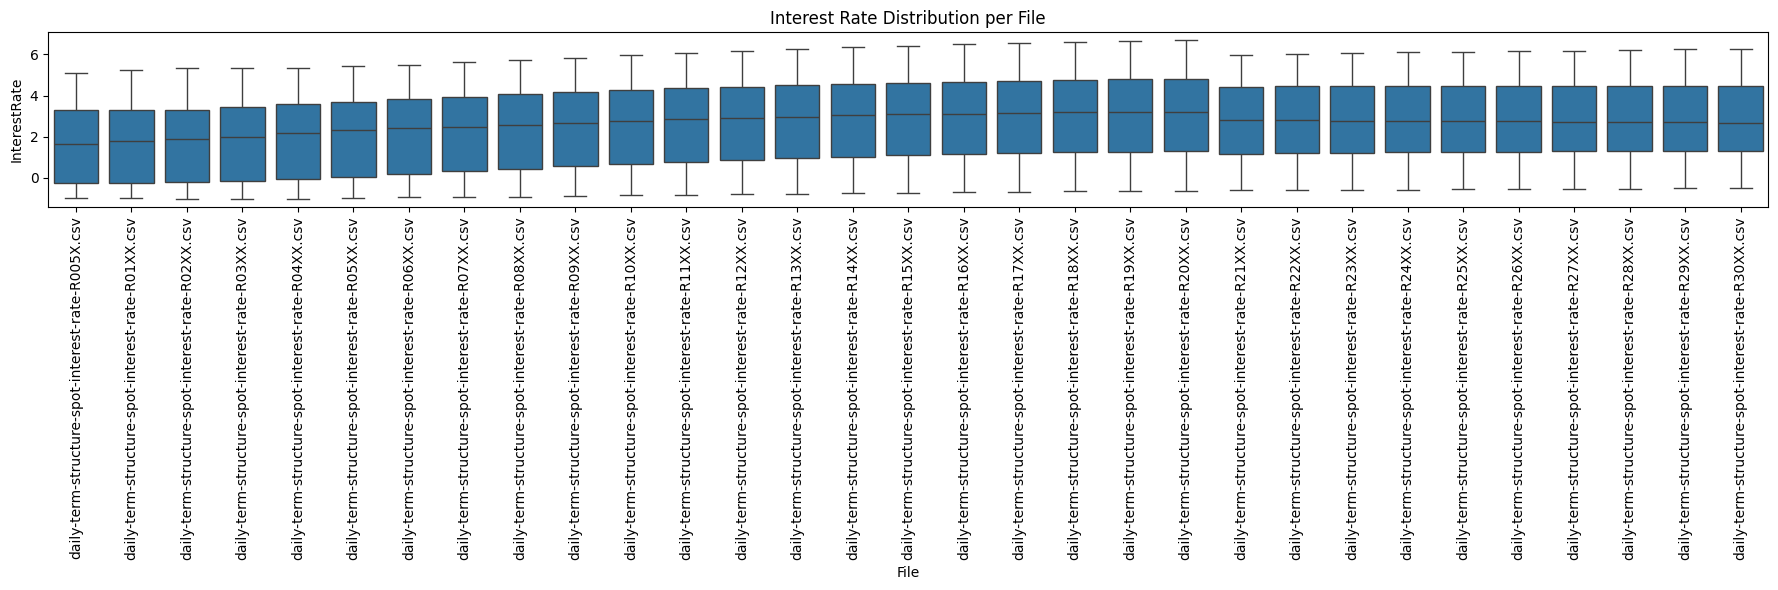

In [ ]:
# For boxplot, tag all records with file name
plot_data = []
for i, df in enumerate(cleaned_dataframes):
    df_temp = df[['InterestRate']].copy()
    df_temp['File'] = csv_files[i]
    plot_data.append(df_temp)

boxplot_df = pd.concat(plot_data)

# Plot
plt.figure(figsize=(18, 6))
sns.boxplot(data=boxplot_df, x='File', y='InterestRate')
plt.xticks(rotation=90)
plt.title('Interest Rate Distribution per File')
plt.tight_layout()
plt.show()

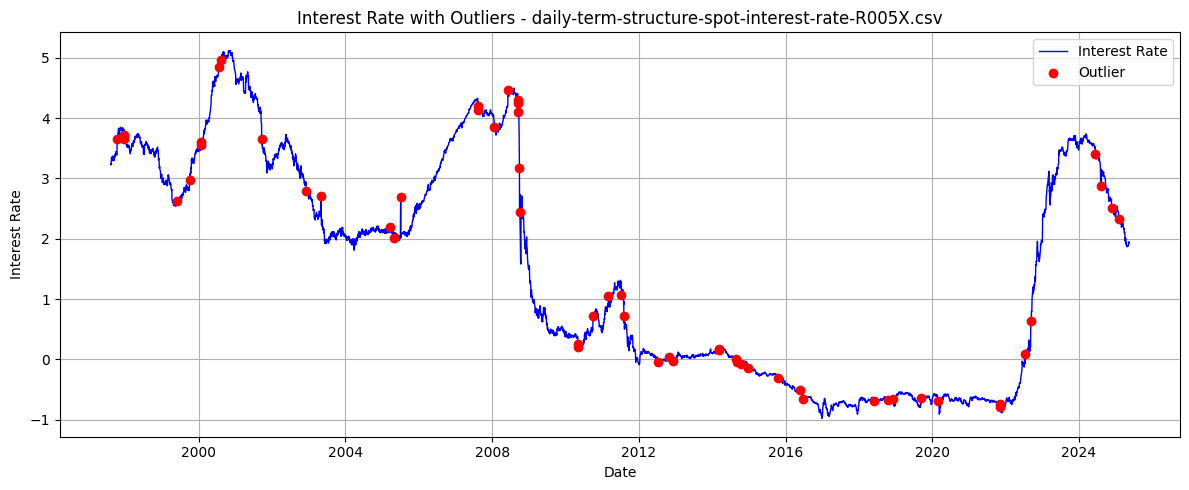

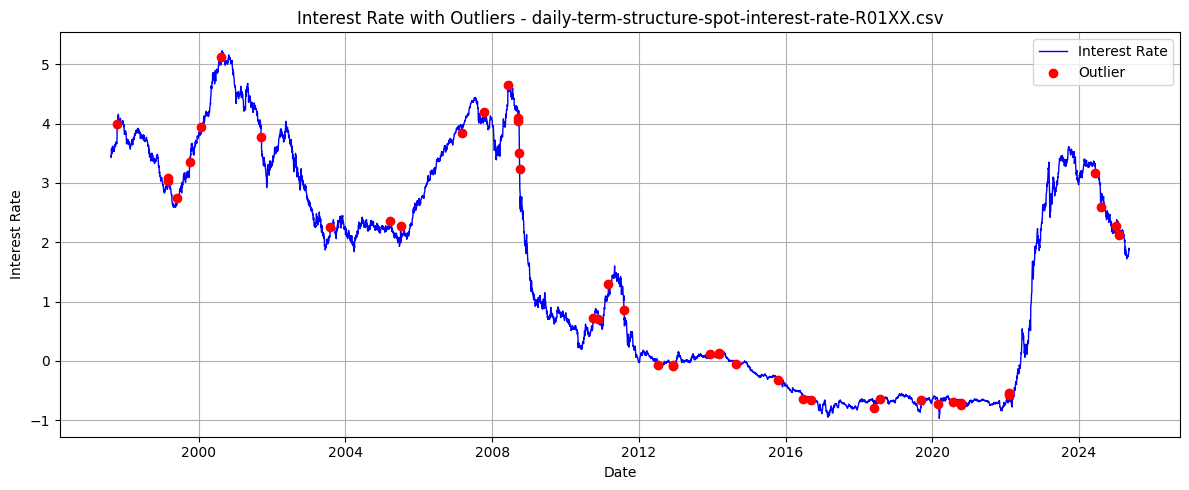

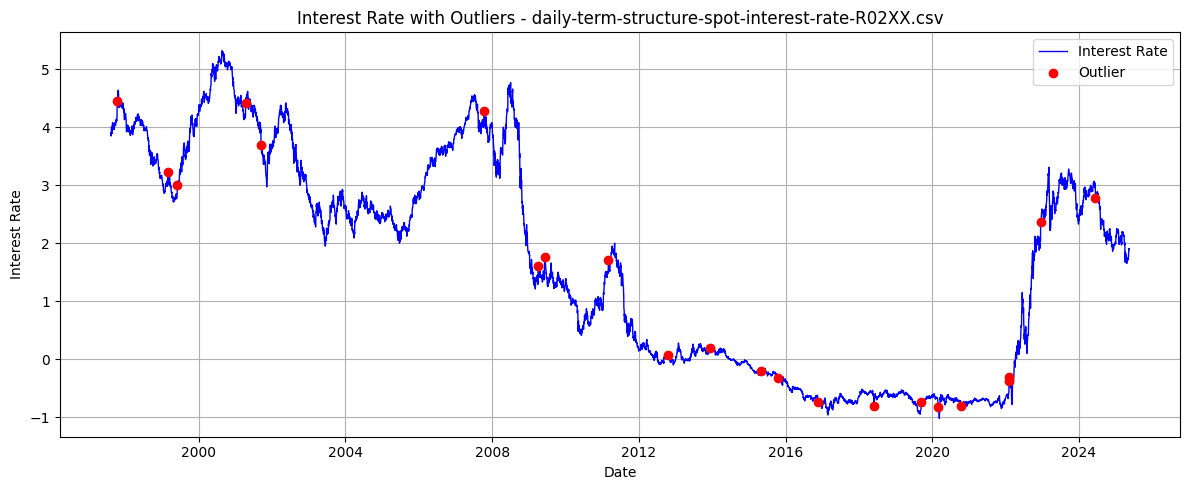

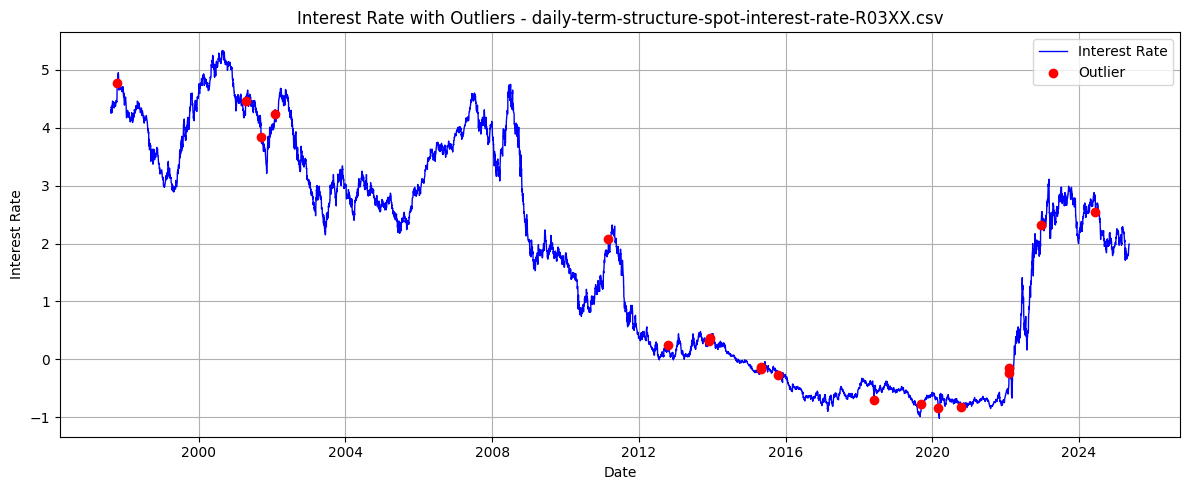

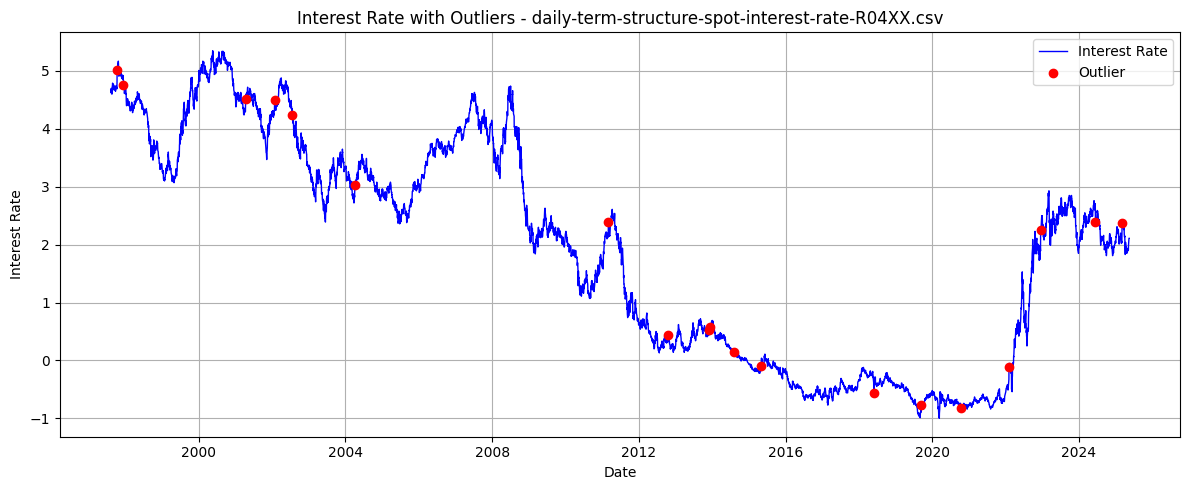

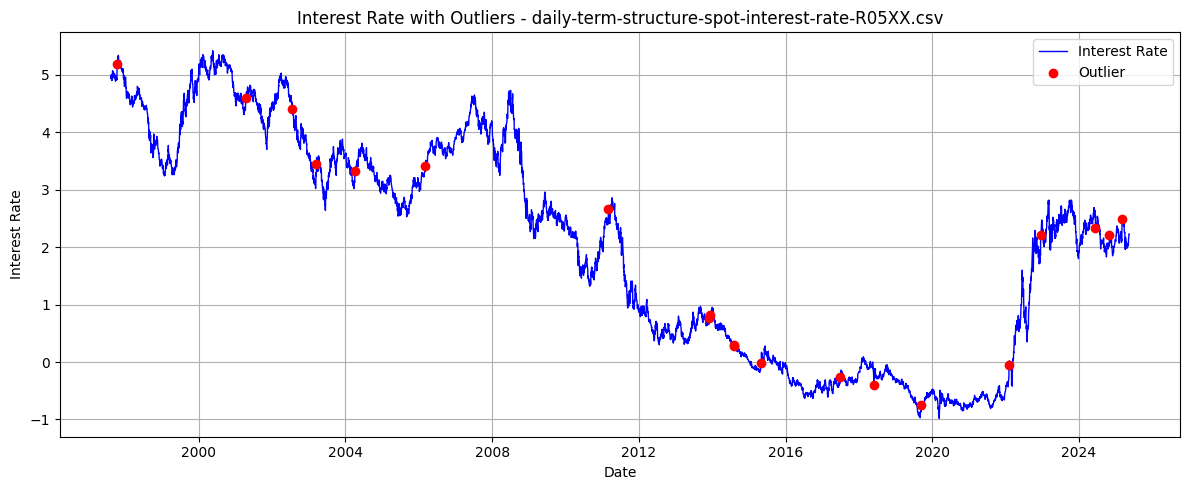

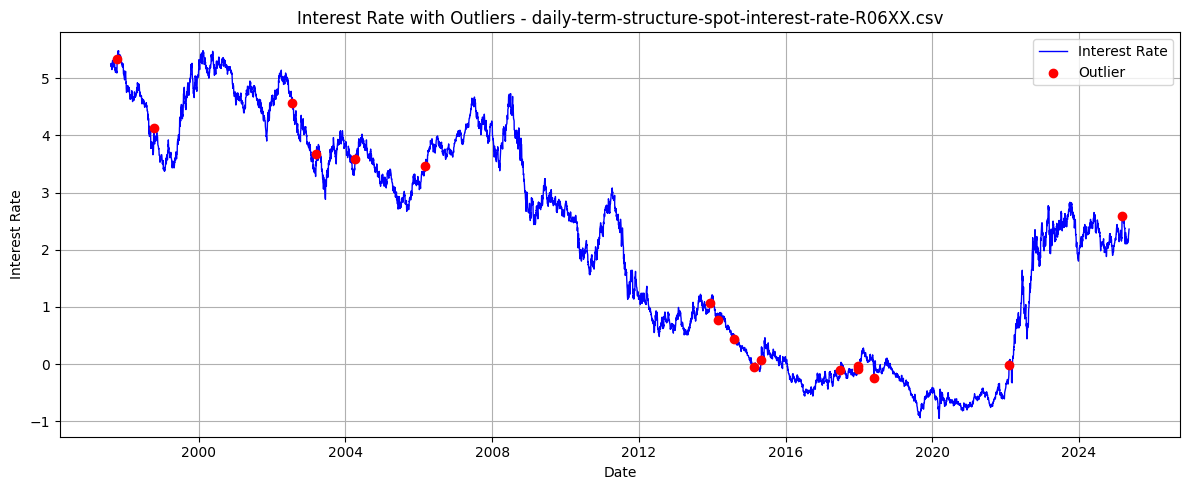

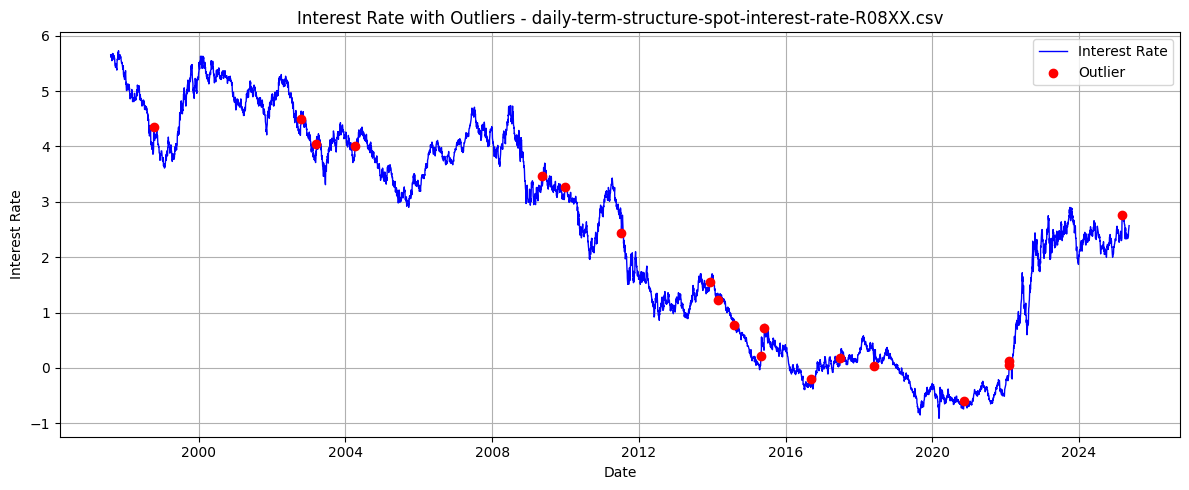

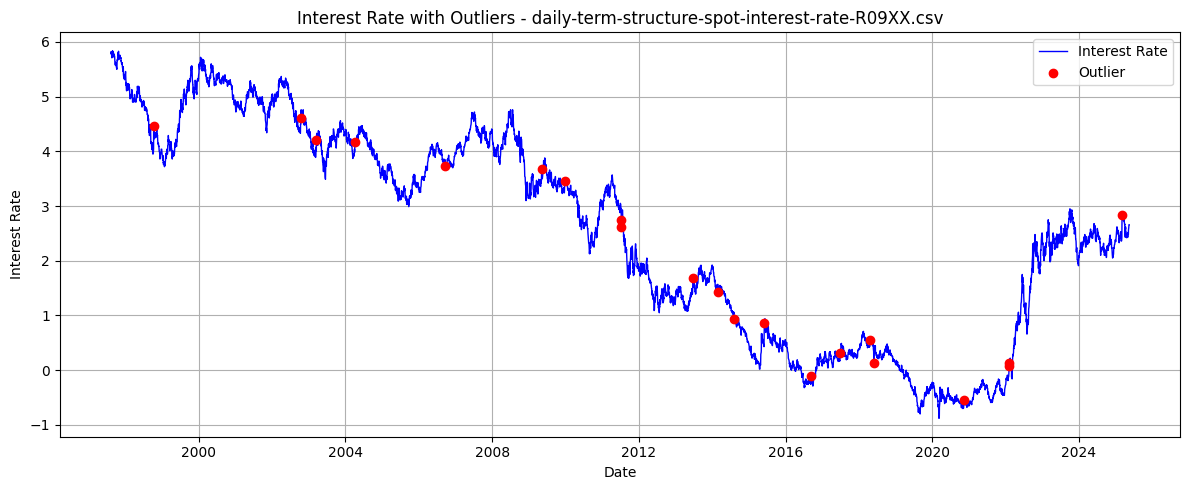

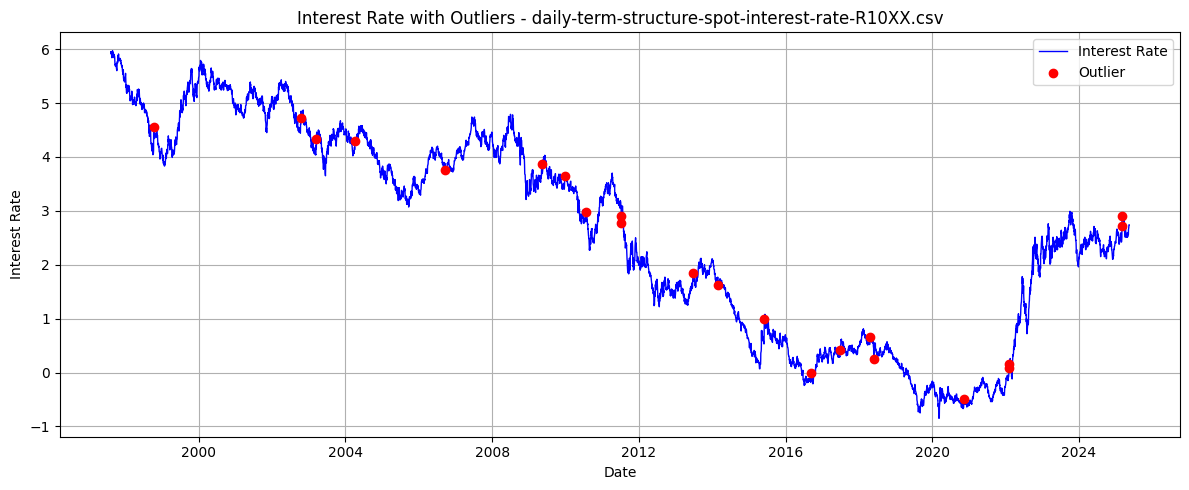

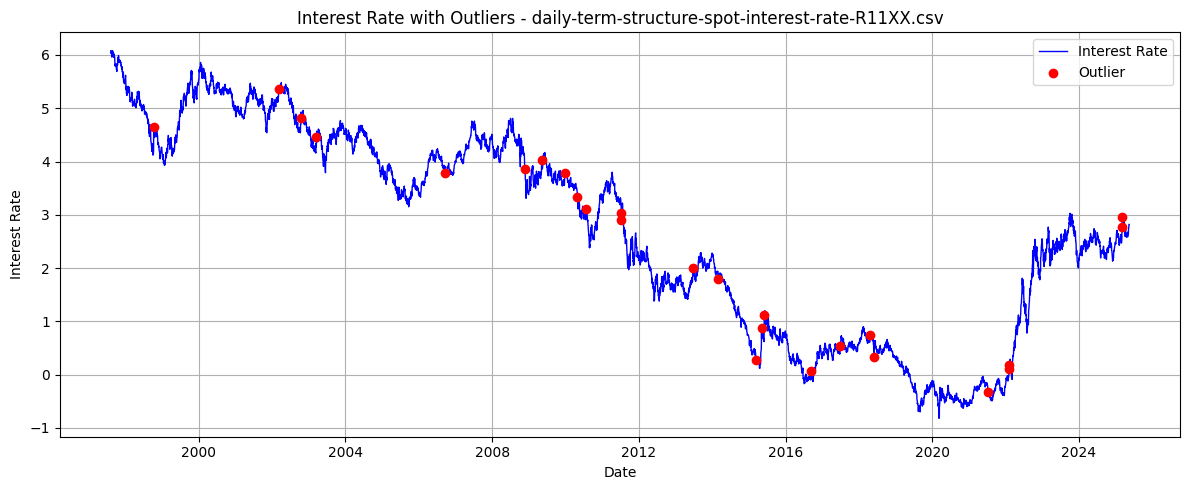

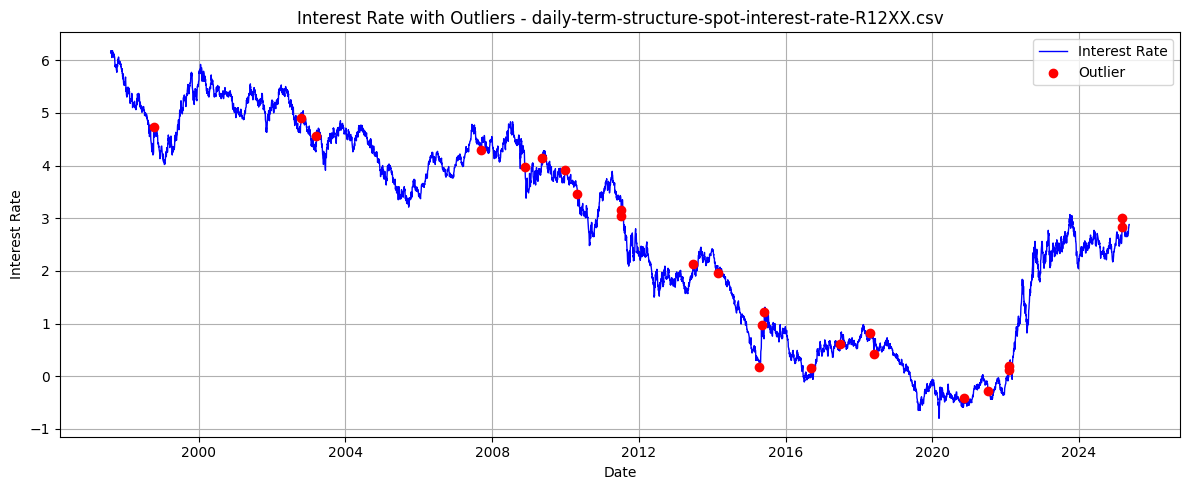

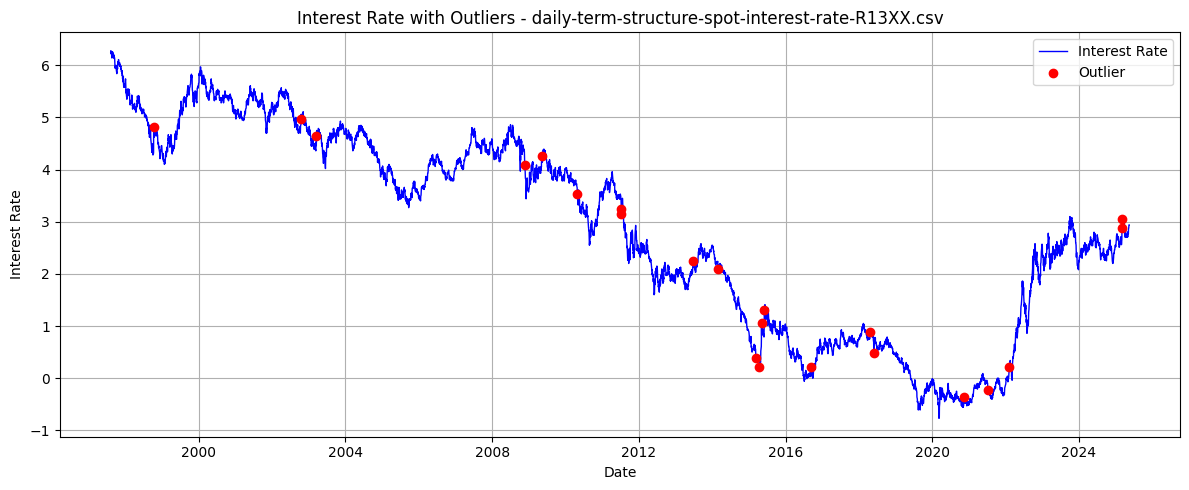

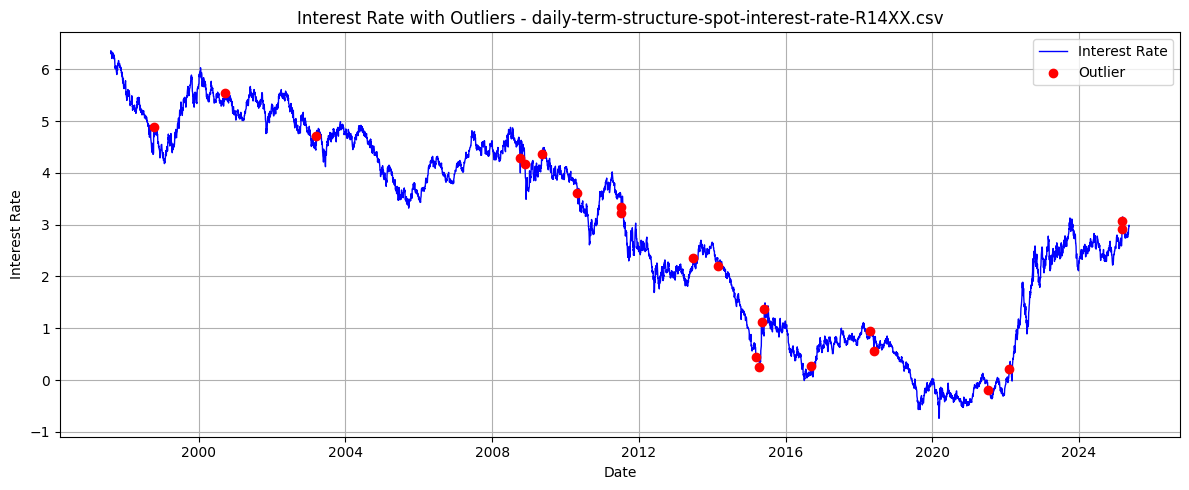

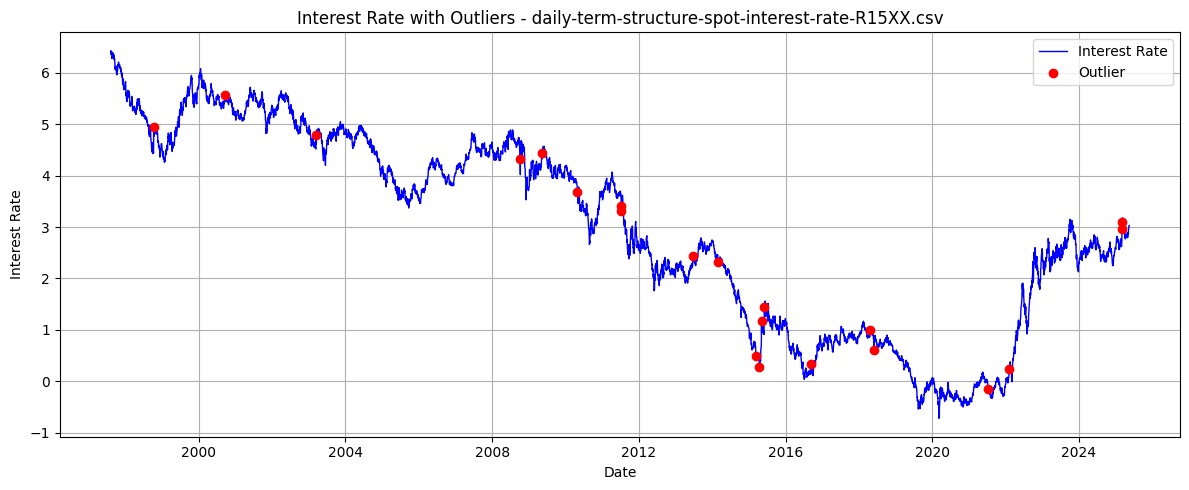

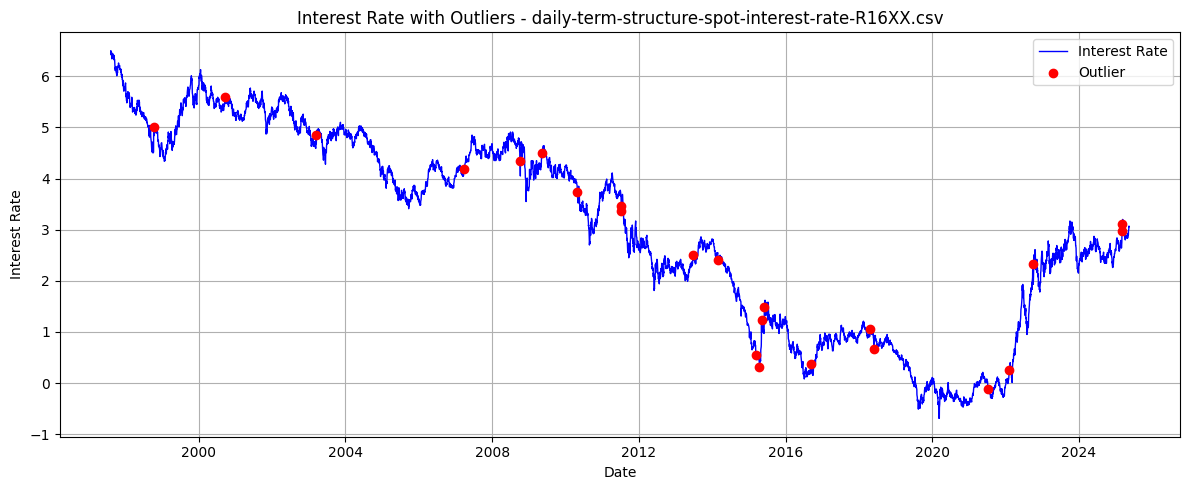

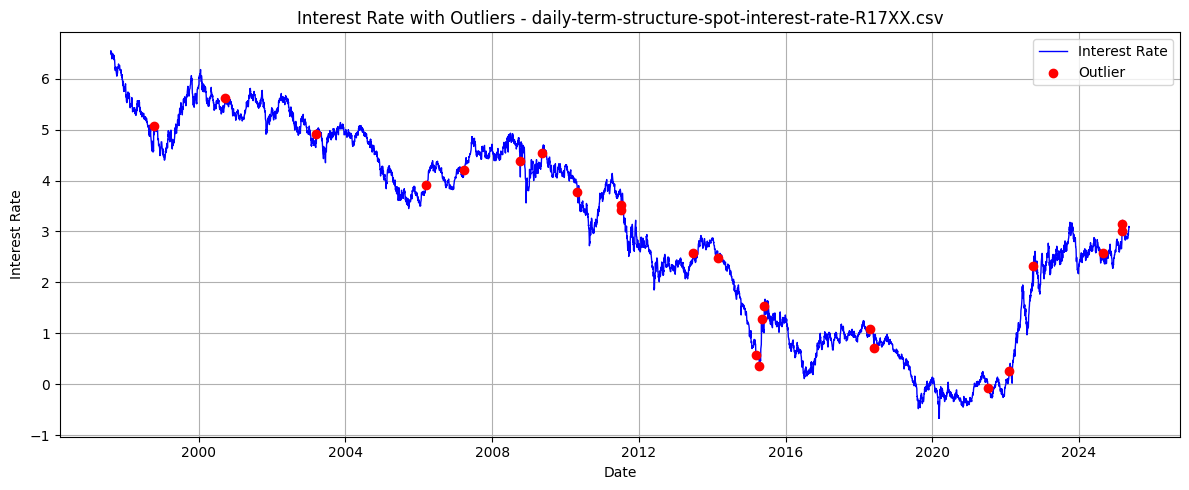

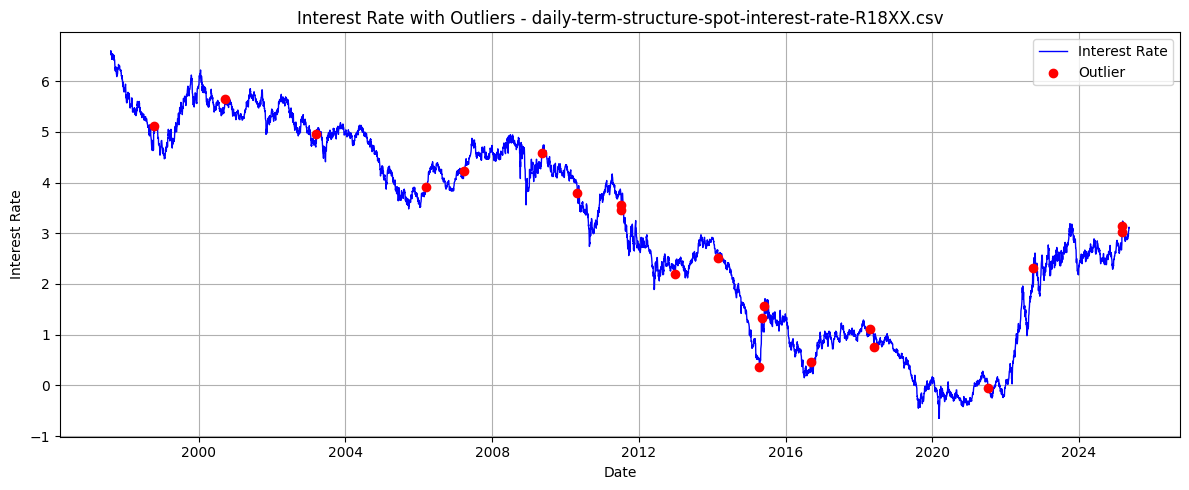

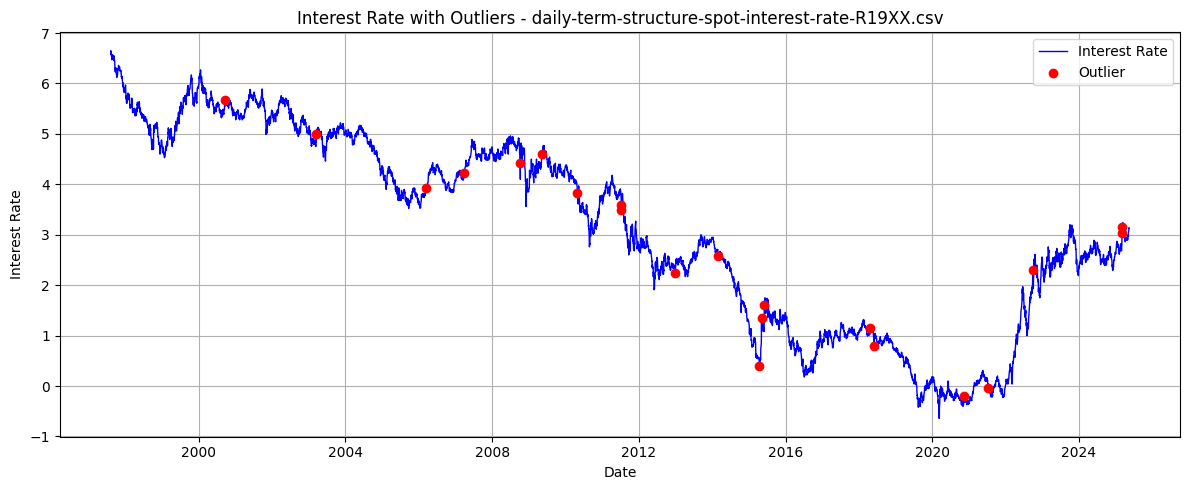

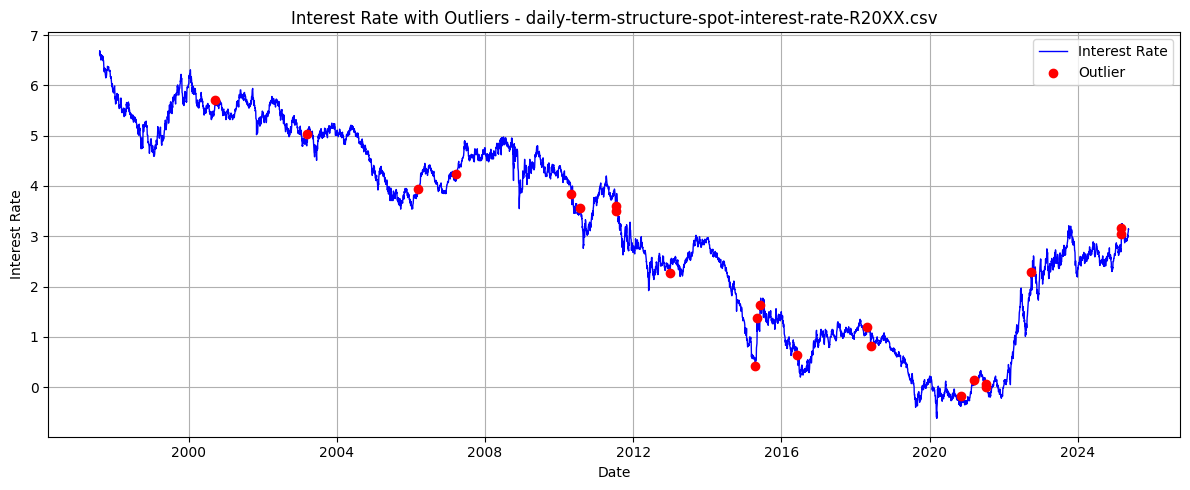

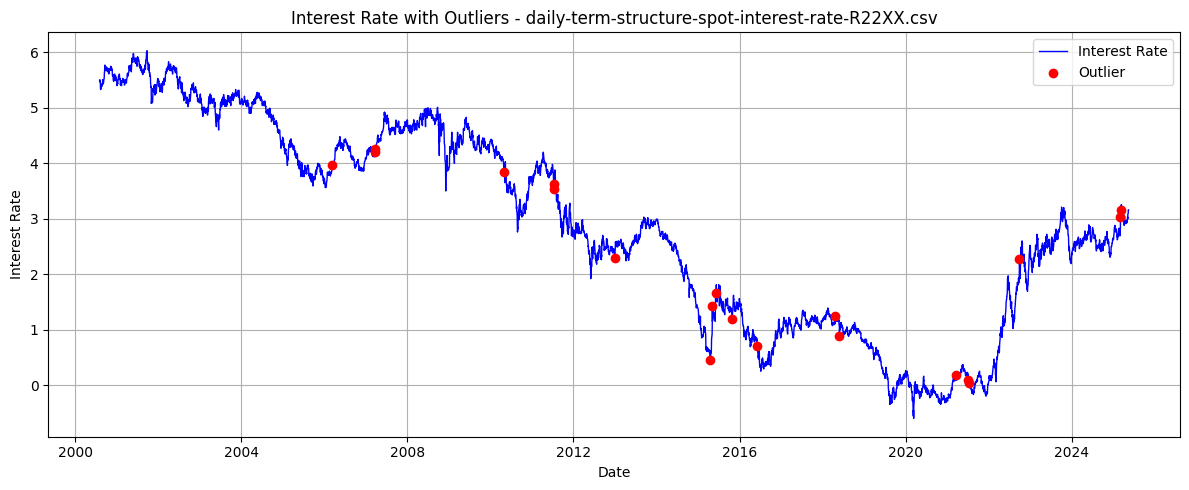

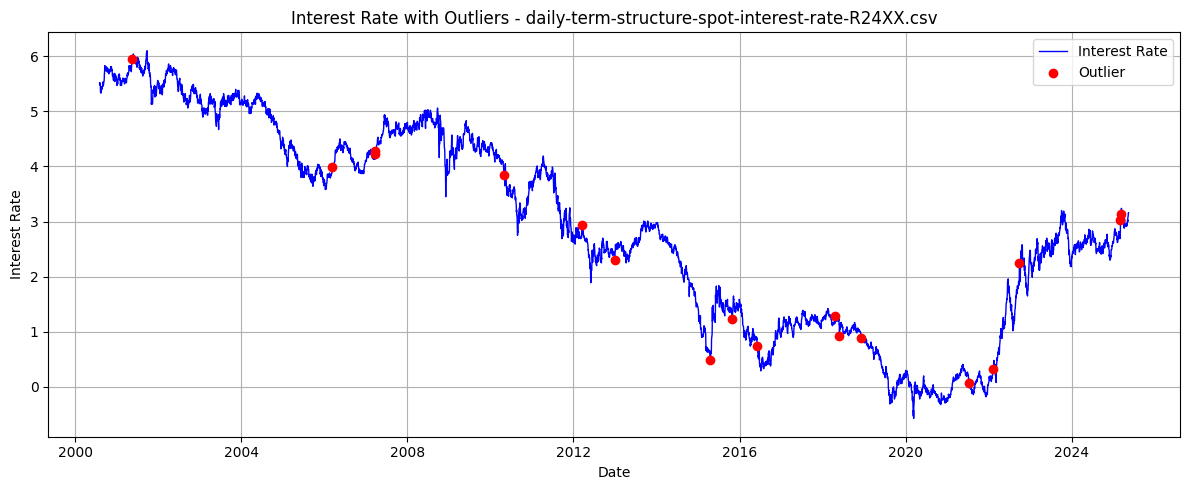

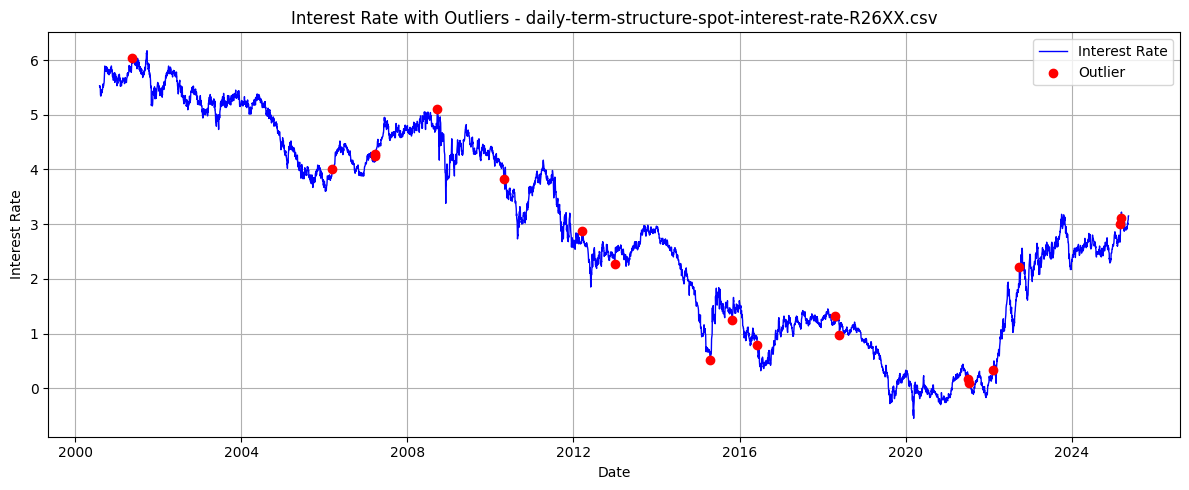

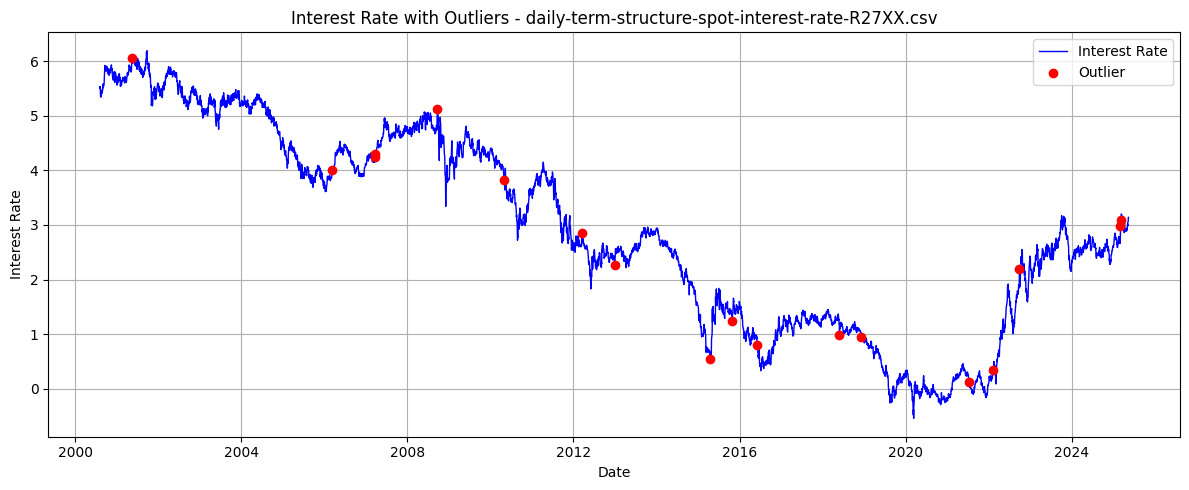

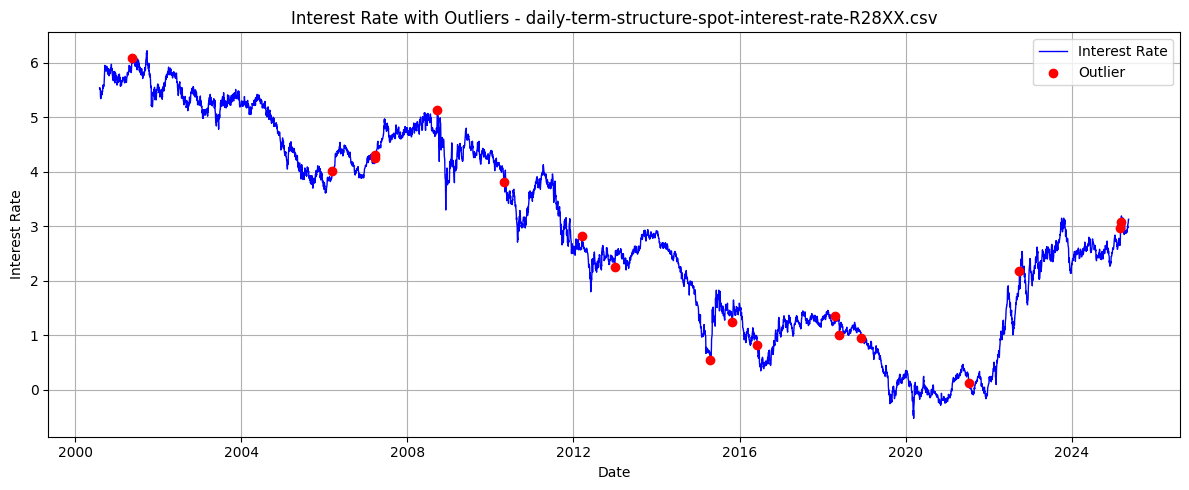

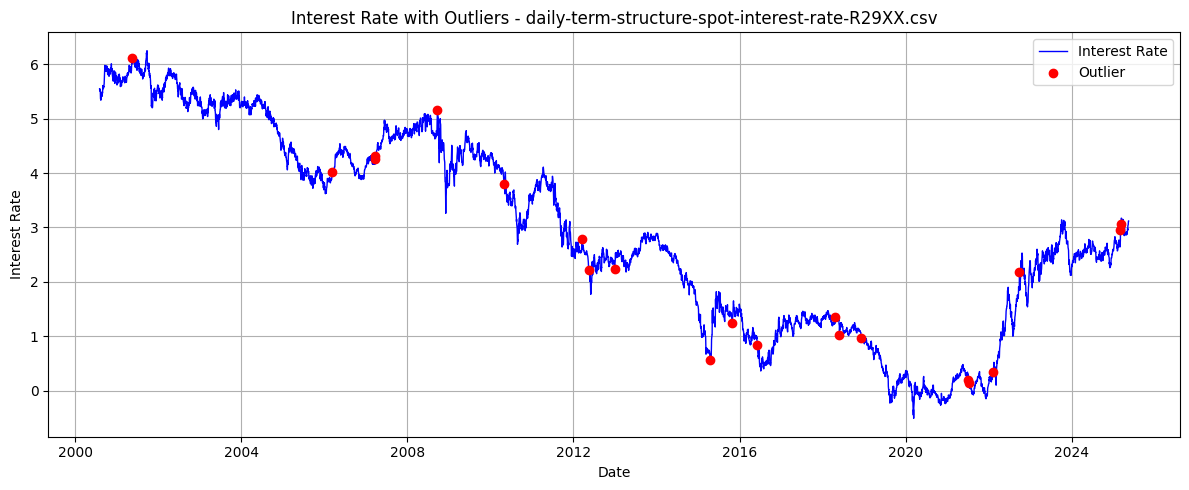

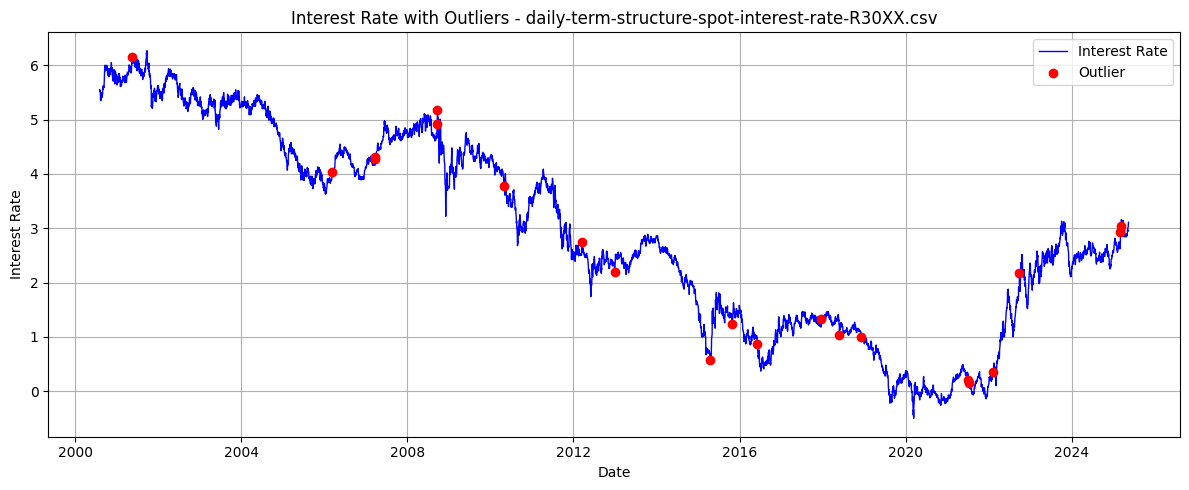

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Parameters
window_size = 20
z_threshold = 3

# Loop over all files
for i, df in enumerate(cleaned_dataframes):
    df = df.copy()  # Prevent altering original
    df.sort_values('Date', inplace=True)

    # Calculate rolling mean and std
    df['RollingMean'] = df['InterestRate'].rolling(window=window_size, min_periods=10).mean()
    df['RollingStd'] = df['InterestRate'].rolling(window=window_size, min_periods=10).std()

    # Z-score calculation
    df['ZScore'] = (df['InterestRate'] - df['RollingMean']) / df['RollingStd']

    # Identify outliers
    df['Outlier'] = df['ZScore'].abs() > z_threshold

    # Plot: interest rate with outliers
    plt.figure(figsize=(12, 5))
    plt.plot(df['Date'], df['InterestRate'], label='Interest Rate', color='blue', linewidth=1)
    plt.scatter(df.loc[df['Outlier'], 'Date'], df.loc[df['Outlier'], 'InterestRate'],
                color='red', label='Outlier', zorder=5)

    plt.title(f'Interest Rate with Outliers - {csv_files[i]}')
    plt.xlabel('Date')
    plt.ylabel('Interest Rate')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
rolling_outlier_summary = []

for i, df in enumerate(cleaned_dataframes):
    df = df.copy()
    df['RollingMean'] = df['InterestRate'].rolling(window=20, min_periods=10).mean()
    df['RollingStd'] = df['InterestRate'].rolling(window=20, min_periods=10).std()
    df['ZScore'] = (df['InterestRate'] - df['RollingMean']) / df['RollingStd']
    df['Outlier'] = df['ZScore'].abs() > 3

    outlier_rows = df[df['Outlier']]

    rolling_outlier_summary.append({
        'File': csv_files[i],
        'Rolling Outlier Count': len(outlier_rows),
        'Max Outlier Value': outlier_rows['InterestRate'].max(),
        'Min Outlier Value': outlier_rows['InterestRate'].min()
    })

rolling_outlier_df = pd.DataFrame(rolling_outlier_summary)
display(rolling_outlier_df)


File  Rolling Outlier Count  \
0   daily-term-structure-spot-interest-rate-R005X.csv                     55   
1   daily-term-structure-spot-interest-rate-R01XX.csv                     45   
2   daily-term-structure-spot-interest-rate-R02XX.csv                     22   
3   daily-term-structure-spot-interest-rate-R03XX.csv                     19   
4   daily-term-structure-spot-interest-rate-R04XX.csv                     19   
5   daily-term-structure-spot-interest-rate-R05XX.csv                     20   
6   daily-term-structure-spot-interest-rate-R06XX.csv                     17   
7   daily-term-structure-spot-interest-rate-R07XX.csv                     19   
8   daily-term-structure-spot-interest-rate-R08XX.csv                     19   
9   daily-term-structure-spot-interest-rate-R09XX.csv                     21   
10  daily-term-structure-spot-interest-rate-R10XX.csv                     22   
11  daily-term-structure-spot-interest-rate-R11XX.csv                     26   
12  daily-term-structure-spot-interest-rate-R12XX.csv                     25   
13  daily-term-structure-spot-interest-rate-R13XX.csv                     22   
14  daily-term-structure-spot-interest-rate-R14XX.csv                     22   
15  daily-term-structure-spot-interest-rate-R15XX.csv                     21   
16  daily-term-structure-spot-interest-rate-R16XX.csv                     23   
17  daily-term-structure-spot-interest-rate-R17XX.csv                     24   
18  daily-term-structure-spot-interest-rate-R18XX.csv                     21   
19  daily-term-structure-spot-interest-rate-R19XX.csv                     21   
20  daily-term-structure-spot-interest-rate-R20XX.csv                     22   
21  daily-term-structure-spot-interest-rate-R21XX.csv                     20   
22  daily-term-structure-spot-interest-rate-R22XX.csv                     20   
23  daily-term-structure-spot-interest-rate-R23XX.csv                     17   
24  daily-term-structure-spot-interest-rate-R24XX.csv                     18   
25  daily-term-structure-spot-interest-rate-R25XX.csv                     16   
26  daily-term-structure-spot-interest-rate-R26XX.csv                     19   
27  daily-term-structure-spot-interest-rate-R27XX.csv                     18   
28  daily-term-structure-spot-interest-rate-R28XX.csv                     18   
29  daily-term-structure-spot-interest-rate-R29XX.csv                     21   
30  daily-term-structure-spot-interest-rate-R30XX.csv                     21   

    Max Outlier Value  Min Outlier Value  
0                4.97              -0.79  
1                5.13              -0.80  
2                4.45              -0.82  
3                4.77              -0.84  
4                5.01              -0.83  
5                5.19              -0.75  
6                5.34              -0.24  
7                4.68              -0.65  
8                4.49              -0.60  
9                4.61              -0.55  
10               4.72              -0.50  
11               5.36              -0.33  
12               4.90              -0.41  
13               4.97              -0.37  
14               5.54              -0.19  
15               5.57              -0.15  
16               5.59              -0.11  
17               5.62              -0.08  
18               5.65              -0.05  
19               5.68              -0.20  
20               5.71              -0.18  
21               5.74              -0.16  
22               4.26               0.04  
23               5.92               0.06  
24               5.95               0.07  
25               5.99               0.09  
26               6.03               0.10  
27               6.06               0.12  
28               6.09               0.13  
29               6.12               0.14  
30               6.15               0.15

In [ ]:
# Merge all datasets into one by 'Date' column
merged_df = pd.DataFrame()
for i, df in enumerate(cleaned_dataframes):
    temp = df[['Date', 'InterestRate']].copy()
    temp = temp.rename(columns={'InterestRate': csv_files[i]})
    if merged_df.empty:
        merged_df = temp
    else:
        merged_df = pd.merge(merged_df, temp, on='Date', how='outer')


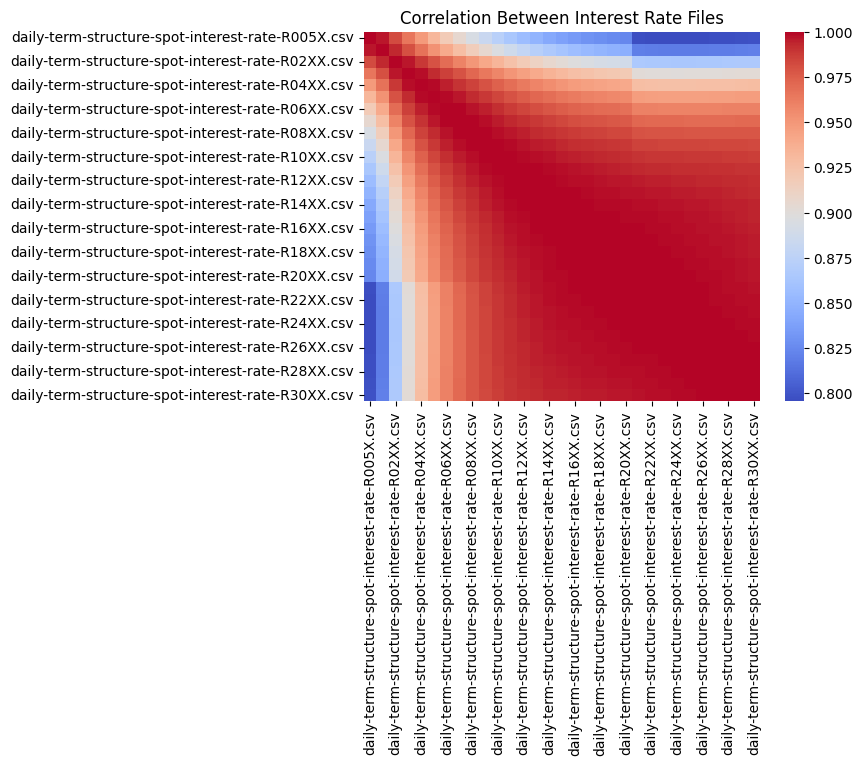

In [ ]:
# Pearson correlation matrix
correlation_matrix = merged_df.drop(columns=['Date']).corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Between Interest Rate Files")
plt.show()


In [ ]:
plt.figure(figsize=(14, 6))
for i, col in enumerate(merged_df.columns[1:]):
    sns.kdeplot(data=merged_df[col], label=col, linewidth=1)
plt.title("Distribution of Interest Rates Across Files")
plt.legend(fontsize=7, ncol=2)
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(14, 6))
for col in merged_df.columns[1:]:
    rolling_std = merged_df[col].rolling(window=30).std()
    plt.plot(merged_df['Date'], rolling_std, label=col)
plt.title("30-Day Rolling Std Dev (Volatility) per File")
plt.legend(fontsize=7, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()
